# import library

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.cluster import hierarchy as hc
import matplotlib
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

%matplotlib inline
warnings.filterwarnings(action='ignore')

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [2]:
dir_root = '../../../'
current_dir = os.getcwd()

dir_master = os.path.join(dir_root, '01. Data','00. master_data')
dir_processed = os.path.join(dir_root, '01. Data','02. 재무지표2', '01. preprocessed')
dir_result = os.path.join(current_dir, 'result')

# Accenture

## Load data

In [3]:
raw_file_name = "Accenture_non_shift_clean_total_v1.1.csv"

In [4]:
# df = pd.read_excel(os.path.join(dir_processed, 'ACN.xlsx'))
# df = pd.read_csv(os.path.join(dir_processed, 'clean_data_with_y1y2.csv'))
# df = pd.read_csv(os.path.join(dir_processed, raw_file_name)) 
df = pd.read_csv(os.path.join(dir_processed, raw_file_name))

# read_excel -> read_csv 변경
# C:\Users\10188\Desktop\기업가치\clean_data


# master = pd.read_excel(os.path.join(dir_master, '해외기업 재무index 분류(Master)_0614.xlsx'))
# master = pd.read_excel(os.path.join(dir_master, 'Accenture_Handwork.xlsx'), sheet_name='Desc')
master = pd.read_excel(os.path.join(dir_master, 'desc_v2.2.xlsx'), sheet_name='desc')

In [5]:
df['Date_x'] = pd.to_datetime(df['Date_x'])
# df['Date_quarter'] = pd.to_datetime(df['Date_quarter'])
# df = df.drop('Unnamed: 0', axis=1)
master = master.drop('Unnamed: 0', axis=1)
master = master.iloc[:,:5]
# master.columns = master.iloc[0,:]
# master = master.drop(0, axis=0).reset_index(drop=True)

# del df['DPS-Common-Net-Issue-ByAnnouncementDate1']
# df['Date_quarter'] = pd.to_datetime(df['Date_quarter'])
# df = df.drop('Unnamed: 0', axis=1)
# master.columns = master.iloc[0,:]
# master = master.drop(0, axis=0).reset_index(drop=True)


In [6]:
df.shape

(76, 292)

In [7]:
master

,raw,no,variable,group,importance
0,Date_x,1,Date_x,DT,9
1,BS_Earnings Quality Score,2,BS_Earnings Quality Score,BS,5
2,BS_Cash and Short Term Investments,3,BS_Cash and Short Term Investments,BS,5
3,BS_Cash & Equivalents,4,BS_Cash & Equivalents,BS,5
4,BS_Short Term Investments,5,BS_Short Term Investments,BS,5
...,...,...,...,...,...
557,Y4,558,EV_EBITDA,YY,9
558,"BS_Non-Current Marketable Securities,Suppl.",559,"BS_Non-Current Marketable Securities,Suppl.",BS,5
559,BS_Payable/Accrued,560,BS_Payable/Accrued,BS,5
560,BS_Wgt Avg Rem Lease Term (Yrs)-Fin Lease,561,BS_Wgt Avg Rem Lease Term (Yrs)-Fin Lease,BS,5


## Correlation X~X

In [8]:
# x값이 300개 이상일 때는 변수 먼저 제거 후 dendrogram 그리는 것도 괜찮은 방법

In [9]:
date = 'Date_x'
y1 = 'close'
y2 = 'close_weighted'
y3 = 'PBR'
y4 = 'EV_EBITDA'

col = [x for x in df.columns if (x not in [date, y1, y2, y3])]
# col = [x for x in df.columns if (x not in [date, y, 'Close_weighted'])]
# limit = 0.1
limit = 0.1

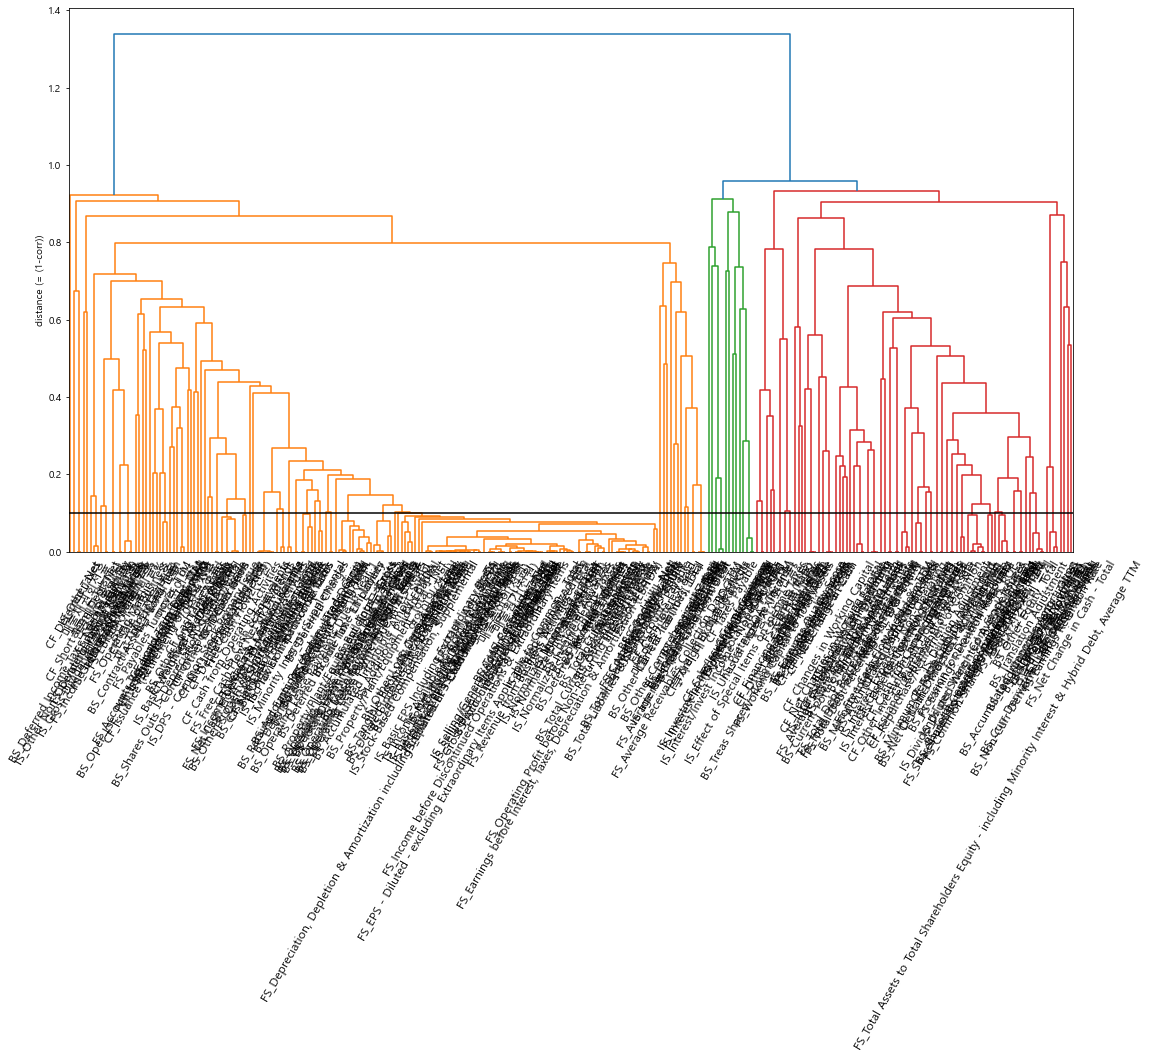

In [10]:
distance = 1 - df[col].corr()   
distance.mask(distance<0, 0, inplace=True)
# 0 <= distance <= 2
# distance = 0 이면 corr = 1
# distance = 2 이면 corr = -1

corr_condensed = hc.distance.squareform(distance)
z = hc.linkage(corr_condensed, method='average')

plt.figure(figsize=(18,10))
plt.ylabel('distance (= (1-corr))')
dendrogram = hc.dendrogram(z, labels=distance.columns, leaf_font_size=12, leaf_rotation=60)
plt.axhline(y=limit, c='k')
plt.show()

Text(0, 0.5, 'number of clusters')

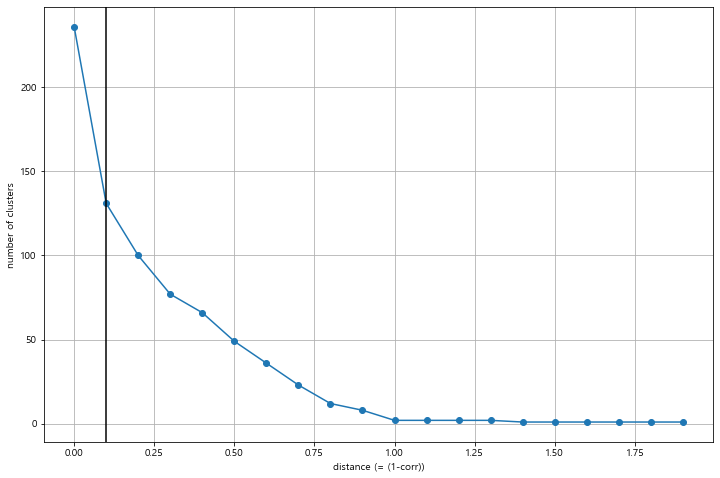

In [11]:
count = []
index = []
for i in np.arange(0, 2, 0.1):
    count.append(len(np.unique(hc.fcluster(z, t=i, criterion='distance'))))
    index.append(i)

plt.figure(figsize=(12,8))
plt.grid()
plt.plot(index, count, marker='o')
plt.axvline(limit, color='black')
plt.xlabel('distance (= (1-corr))')
plt.ylabel('number of clusters')

In [12]:
result = pd.DataFrame({'var':distance.columns, 'cluster':hc.fcluster(z, t=limit, criterion='distance')})
count_result = pd.DataFrame(pd.DataFrame(result['cluster'].value_counts()).reset_index())
count_result.columns = ['cluster', '# of variables']

In [13]:
print('Head : ')
display(count_result.head(10))
print('\nTail : ')
display(count_result.tail(10))

Head : 


,cluster,# of variables
0,46,75
1,44,10
2,114,6
3,45,6
4,32,6
5,34,6
6,39,4
7,122,4
8,118,4
9,126,3



Tail : 


,cluster,# of variables
121,110,1
122,29,1
123,91,1
124,36,1
125,19,1
126,69,1
127,2,1
128,27,1
129,54,1
130,68,1


### Plot scatter plot, correlation matrix

In [14]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

In [15]:
len((result.cluster.value_counts()>1)[(result.cluster.value_counts()>1)].index)

47

In [16]:
def correlation_matrix (result, master, df, m):
    n=m
    
    for i in (result.cluster.value_counts()>1)[(result.cluster.value_counts()>1)].index:
        tmp = df.loc[:,result[result.cluster==i]['var']]
        cluster_lot = tmp.columns
        split_cluster_lot = [cluster_lot[i * n:(i + 1) * n] for i in range((len(cluster_lot) + n - 1) // n )]
        
        print('\ncluster '+ str(i) + '\n' + '# of variable = ' + str(result.cluster.value_counts()[result.cluster.value_counts().index==i].values[0]))   
        print('\nDisplay the description of variables : ')
        
#         show = master[master.variable.isin(cluster_lot)].sort_values('importance', ascending=True)
        show = master[master.variable.isin(cluster_lot)]
        show = show.sort_values(['importance', 'group','variable'], ascending=[True, True, False])
        display(show)
        
        print('\nDisplay scatter & correlation plot per '+str(m)+' variables : ')
        for j in split_cluster_lot:
            tmp = df.loc[:,j]
            sns.set(style='white', font="Malgun Gothic", font_scale=1.8)
            g = sns.PairGrid(tmp, aspect=1.4, diag_sharey=False)
            # g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
            g.map_lower(sns.regplot, line_kws={'color': 'black'})
            g.map_diag(sns.distplot, kde_kws={'color': 'black'})
            g.map_upper(corrdot)
            plt.show()
            print('\n\n')
        print('==================================================================================================================')
        
    cluster_1 = (result.cluster.value_counts()>1)[~(result.cluster.value_counts()>1)].index
    split_cluster_1 = [cluster_1[i * n:(i + 1) * n] for i in range((len(cluster_1) + n - 1) // n )]

    for i in split_cluster_1:
        tmp = df.loc[:,result[result.cluster.isin(i)]['var']]

        print('\ncluster '+ str(list(i)) + '\n' + '# of variable = 1\n'+ 'not clustered')
        sns.set(style='white', font="Malgun Gothic", font_scale=1.8)
        g = sns.PairGrid(tmp, aspect=1.4, diag_sharey=False)
        # g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
        g.map_lower(sns.regplot, line_kws={'color': 'black'})
        g.map_diag(sns.distplot, kde_kws={'color': 'black'})
        g.map_upper(corrdot)
        plt.show()
        print('\n\n')
        print('==================================================================================================================')
        

In [17]:
# correlation_matrix(result, master, df, 8)

In [18]:
# x~x는 전체 기간에 대해서만 분석하고 있음

## feature selection

In [19]:
n=8
keep_lst = pd.DataFrame()
cnt_var = 0
cnt_g = 0
for i in (result.cluster.value_counts()>1)[(result.cluster.value_counts()>1)].index:
    cnt_g += 1
    tmp = df.loc[:,result[result.cluster==i]['var']]
    cluster_lot = tmp.columns
    split_cluster_lot = [cluster_lot[i * n:(i + 1) * n] for i in range((len(cluster_lot) + n - 1) // n )]

    print('\ncluster '+ str(i) + '\n' + '# of variable = ' + str(result.cluster.value_counts()[result.cluster.value_counts().index==i].values[0]))   
    cnt_var += result.cluster.value_counts()[result.cluster.value_counts().index==i].values[0]
    print('\nDisplay the description of variables : ')

    show = master[master.variable.isin(cluster_lot)]
    show['cluster'] = str(i)
    
#     show = show[show['group'].apply(lambda x: x.encode().isalpha()) == True]
    show = show.sort_values(['importance', 'group','variable'], ascending=[True, True, False]).reset_index(drop=True)
    
    # importance=0인 것 먼저 빼놓기
    cluster_lst = pd.DataFrame()
    cluster_lst = pd.concat([cluster_lst, show.loc[show['importance']==0,:]])
    
    # importance가 중요한거를 미리 빼놓고, group 기준으로 중복되는 항목 삭제
    show2 = show.loc[show['importance']==show['importance'].min(),:]
    show2.drop_duplicates('group', inplace=True, keep='first')
    show2.reset_index(drop=True, inplace=True)
    
    print("show2::::")
    display(show2)
    cluster_lst = pd.merge(cluster_lst, show2, how='outer', on=['raw','no','variable','group','importance','cluster'])
    print("cluster_lst::::")
    display(cluster_lst)
    eng = False
    for j in range(len(cluster_lst)):
        if cluster_lst.loc[j, 'group'].encode().isalpha() == True:
            eng = True
            
    if eng == True:
        cluster_lst = cluster_lst.head(1)
#     show2 = show2[show2['group'].apply(lambda x: (x.encode().isalpha()) == False)]
 
    keep_lst = pd.concat([keep_lst, cluster_lst], axis=0)
    
    display(cluster_lst)


cluster 46
# of variable = 75

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,매출액(천원),297,매출액(천원),성장성,0,46
1,매출총이익(천원),299,매출총이익(천원),수익성,0,46


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,매출액(천원),297,매출액(천원),성장성,0,46
1,매출총이익(천원),299,매출총이익(천원),수익성,0,46


,raw,no,variable,group,importance,cluster
0,매출액(천원),297,매출액(천원),성장성,0,46
1,매출총이익(천원),299,매출총이익(천원),수익성,0,46



cluster 44
# of variable = 10

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,"BS_Total Operating Leases, Supplemental",96,"BS_Total Operating Leases, Supplemental",BS,5,44


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,"BS_Total Operating Leases, Supplemental",96,"BS_Total Operating Leases, Supplemental",BS,5,44


,raw,no,variable,group,importance,cluster
0,"BS_Total Operating Leases, Supplemental",96,"BS_Total Operating Leases, Supplemental",BS,5,44



cluster 114
# of variable = 6

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,BS_Total Common Shares Outstanding,68,BS_Total Common Shares Outstanding,BS,5,114
1,Shares used to calculate Diluted EPS - Total,251,FS_Shares used to calculate Diluted EPS - Total,FS,5,114
2,IS_Diluted Weighted Average Shares,201,IS_Diluted Weighted Average Shares,IS,5,114


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,BS_Total Common Shares Outstanding,68,BS_Total Common Shares Outstanding,BS,5,114
1,Shares used to calculate Diluted EPS - Total,251,FS_Shares used to calculate Diluted EPS - Total,FS,5,114
2,IS_Diluted Weighted Average Shares,201,IS_Diluted Weighted Average Shares,IS,5,114


,raw,no,variable,group,importance,cluster
0,BS_Total Common Shares Outstanding,68,BS_Total Common Shares Outstanding,BS,5,114



cluster 45
# of variable = 6

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,무형자산,339,무형자산,안정성,2,45


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,무형자산,339,무형자산,안정성,2,45


,raw,no,variable,group,importance,cluster
0,무형자산,339,무형자산,안정성,2,45



cluster 32
# of variable = 6

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,Free Cash Flow2(천원),306,Free Cash Flow2(천원),수익성,0,32


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,Free Cash Flow2(천원),306,Free Cash Flow2(천원),수익성,0,32


,raw,no,variable,group,importance,cluster
0,Free Cash Flow2(천원),306,Free Cash Flow2(천원),수익성,0,32



cluster 34
# of variable = 6

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,단기투자자산,344,단기투자자산,안정성,1,34


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,단기투자자산,344,단기투자자산,안정성,1,34


,raw,no,variable,group,importance,cluster
0,단기투자자산,344,단기투자자산,안정성,1,34



cluster 39
# of variable = 4

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,이익잉여금(천원),310,이익잉여금(천원),수익성,2,39


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,이익잉여금(천원),310,이익잉여금(천원),수익성,2,39


,raw,no,variable,group,importance,cluster
0,이익잉여금(천원),310,이익잉여금(천원),수익성,2,39



cluster 122
# of variable = 4

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,BS_Other Current Liabilities,44,BS_Other Current Liabilities,BS,5,122


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,BS_Other Current Liabilities,44,BS_Other Current Liabilities,BS,5,122


,raw,no,variable,group,importance,cluster
0,BS_Other Current Liabilities,44,BS_Other Current Liabilities,BS,5,122



cluster 118
# of variable = 4

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,ROE(지배)(비율),329,ROE(지배)(비율),수익성,1,118


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,ROE(지배)(비율),329,ROE(지배)(비율),수익성,1,118


,raw,no,variable,group,importance,cluster
0,ROE(지배)(비율),329,ROE(지배)(비율),수익성,1,118



cluster 126
# of variable = 3

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,영업이익증가율(YoY)(연도),326,영업이익증가율(YoY)(연도),성장성,1,126


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,영업이익증가율(YoY)(연도),326,영업이익증가율(YoY)(연도),성장성,1,126


,raw,no,variable,group,importance,cluster
0,영업이익증가율(YoY)(연도),326,영업이익증가율(YoY)(연도),성장성,1,126



cluster 99
# of variable = 3

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,BS_Minority Interest - Non Redeemable,418,BS_Minority Interest - Non Redeemable,BS,5,99
1,Minority Interest - Total,447,Minority Interest - Total,ET,5,99


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,BS_Minority Interest - Non Redeemable,418,BS_Minority Interest - Non Redeemable,BS,5,99
1,Minority Interest - Total,447,Minority Interest - Total,ET,5,99


,raw,no,variable,group,importance,cluster
0,BS_Minority Interest - Non Redeemable,418,BS_Minority Interest - Non Redeemable,BS,5,99



cluster 74
# of variable = 3

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,IS_Unusual Expense (Income),170,IS_Unusual Expense (Income),IS,5,74


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,IS_Unusual Expense (Income),170,IS_Unusual Expense (Income),IS,5,74


,raw,no,variable,group,importance,cluster
0,IS_Unusual Expense (Income),170,IS_Unusual Expense (Income),IS,5,74



cluster 62
# of variable = 3

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,채무총계,345,채무총계,안정성,1,62


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,채무총계,345,채무총계,안정성,1,62


,raw,no,variable,group,importance,cluster
0,채무총계,345,채무총계,안정성,1,62



cluster 106
# of variable = 3

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,"CF_Other Investing Cash Flow Items, Total",125,"CF_Other Investing Cash Flow Items, Total",CF,5,106


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,"CF_Other Investing Cash Flow Items, Total",125,"CF_Other Investing Cash Flow Items, Total",CF,5,106


,raw,no,variable,group,importance,cluster
0,"CF_Other Investing Cash Flow Items, Total",125,"CF_Other Investing Cash Flow Items, Total",CF,5,106



cluster 88
# of variable = 3

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,BS_Earnings Quality Score,2,BS_Earnings Quality Score,BS,5,88
1,CF_Earnings Quality Score,107,CF_Earnings Quality Score,CF,5,88
2,IS_Earnings Quality Score,155,IS_Earnings Quality Score,IS,5,88


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,BS_Earnings Quality Score,2,BS_Earnings Quality Score,BS,5,88
1,CF_Earnings Quality Score,107,CF_Earnings Quality Score,CF,5,88
2,IS_Earnings Quality Score,155,IS_Earnings Quality Score,IS,5,88


,raw,no,variable,group,importance,cluster
0,BS_Earnings Quality Score,2,BS_Earnings Quality Score,BS,5,88



cluster 11
# of variable = 3

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,Opex Margin,352,Opex Margin,수익성,0,11


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,Opex Margin,352,Opex Margin,수익성,0,11


,raw,no,variable,group,importance,cluster
0,Opex Margin,352,Opex Margin,수익성,0,11



cluster 97
# of variable = 3

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,Total Debt Percentage of Total Equity,268,FS_Total Debt Percentage of Total Equity,FS,5,97


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,Total Debt Percentage of Total Equity,268,FS_Total Debt Percentage of Total Equity,FS,5,97


,raw,no,variable,group,importance,cluster
0,Total Debt Percentage of Total Equity,268,FS_Total Debt Percentage of Total Equity,FS,5,97



cluster 107
# of variable = 3

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,"CF_Issuance (Retirement) of Stock, Net",135,"CF_Issuance (Retirement) of Stock, Net",CF,5,107


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,"CF_Issuance (Retirement) of Stock, Net",135,"CF_Issuance (Retirement) of Stock, Net",CF,5,107


,raw,no,variable,group,importance,cluster
0,"CF_Issuance (Retirement) of Stock, Net",135,"CF_Issuance (Retirement) of Stock, Net",CF,5,107



cluster 90
# of variable = 3

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,운전자본증감(천원),301,운전자본증감(천원),안정성,2,90


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,운전자본증감(천원),301,운전자본증감(천원),안정성,2,90


,raw,no,variable,group,importance,cluster
0,운전자본증감(천원),301,운전자본증감(천원),안정성,2,90



cluster 22
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,BS_Shares Outs - Common Stock Primary Issue,69,BS_Shares Outs - Common Stock Primary Issue,BS,5,22
1,IS_Basic Weighted Average Shares,196,IS_Basic Weighted Average Shares,IS,5,22


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,BS_Shares Outs - Common Stock Primary Issue,69,BS_Shares Outs - Common Stock Primary Issue,BS,5,22
1,IS_Basic Weighted Average Shares,196,IS_Basic Weighted Average Shares,IS,5,22


,raw,no,variable,group,importance,cluster
0,BS_Shares Outs - Common Stock Primary Issue,69,BS_Shares Outs - Common Stock Primary Issue,BS,5,22



cluster 105
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,"IS_Interest Expense, Net Non-Operating",177,"IS_Interest Expense, Net Non-Operating",IS,5,105


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,"IS_Interest Expense, Net Non-Operating",177,"IS_Interest Expense, Net Non-Operating",IS,5,105


,raw,no,variable,group,importance,cluster
0,"IS_Interest Expense, Net Non-Operating",177,"IS_Interest Expense, Net Non-Operating",IS,5,105



cluster 7
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,순이익률(비율),321,순이익률(비율),수익성,2,7


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,순이익률(비율),321,순이익률(비율),수익성,2,7


,raw,no,variable,group,importance,cluster
0,순이익률(비율),321,순이익률(비율),수익성,2,7



cluster 113
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,IS_Dividends per Share - Com Stock Issue 3,538,IS_Dividends per Share - Com Stock Issue 3,IS,5,113


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,IS_Dividends per Share - Com Stock Issue 3,538,IS_Dividends per Share - Com Stock Issue 3,IS,5,113


,raw,no,variable,group,importance,cluster
0,IS_Dividends per Share - Com Stock Issue 3,538,IS_Dividends per Share - Com Stock Issue 3,IS,5,113



cluster 37
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,IS_Provision for Income Taxes,186,IS_Provision for Income Taxes,IS,5,37


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,IS_Provision for Income Taxes,186,IS_Provision for Income Taxes,IS,5,37


,raw,no,variable,group,importance,cluster
0,IS_Provision for Income Taxes,186,IS_Provision for Income Taxes,IS,5,37



cluster 112
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,CF_Total Cash Dividends Paid,133,CF_Total Cash Dividends Paid,CF,5,112


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,CF_Total Cash Dividends Paid,133,CF_Total Cash Dividends Paid,CF,5,112


,raw,no,variable,group,importance,cluster
0,CF_Total Cash Dividends Paid,133,CF_Total Cash Dividends Paid,CF,5,112



cluster 31
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,CAPEX(천원),327,CAPEX(천원),성장성,1,31


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,CAPEX(천원),327,CAPEX(천원),성장성,1,31


,raw,no,variable,group,importance,cluster
0,CAPEX(천원),327,CAPEX(천원),성장성,1,31



cluster 108
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,CF_Purchase of Fixed Assets,123,CF_Purchase of Fixed Assets,CF,5,108


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,CF_Purchase of Fixed Assets,123,CF_Purchase of Fixed Assets,CF,5,108


,raw,no,variable,group,importance,cluster
0,CF_Purchase of Fixed Assets,123,CF_Purchase of Fixed Assets,CF,5,108



cluster 35
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,BS_Other Long Term Liabilities,53,BS_Other Long Term Liabilities,BS,5,35


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,BS_Other Long Term Liabilities,53,BS_Other Long Term Liabilities,BS,5,35


,raw,no,variable,group,importance,cluster
0,BS_Other Long Term Liabilities,53,BS_Other Long Term Liabilities,BS,5,35



cluster 77
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,ROA(비율),328,ROA(비율),수익성,1,77


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,ROA(비율),328,ROA(비율),수익성,1,77


,raw,no,variable,group,importance,cluster
0,ROA(비율),328,ROA(비율),수익성,1,77



cluster 18
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,"CF_Long Term Debt, Net",144,"CF_Long Term Debt, Net",CF,5,18


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,"CF_Long Term Debt, Net",144,"CF_Long Term Debt, Net",CF,5,18


,raw,no,variable,group,importance,cluster
0,"CF_Long Term Debt, Net",144,"CF_Long Term Debt, Net",CF,5,18



cluster 66
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,IS_Interest/Invest Income - Non-Operating,179,IS_Interest/Invest Income - Non-Operating,IS,5,66


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,IS_Interest/Invest Income - Non-Operating,179,IS_Interest/Invest Income - Non-Operating,IS,5,66


,raw,no,variable,group,importance,cluster
0,IS_Interest/Invest Income - Non-Operating,179,IS_Interest/Invest Income - Non-Operating,IS,5,66



cluster 1
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,"IS_Other, Net",183,"IS_Other, Net",IS,5,1


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,"IS_Other, Net",183,"IS_Other, Net",IS,5,1


,raw,no,variable,group,importance,cluster
0,"IS_Other, Net",183,"IS_Other, Net",IS,5,1



cluster 82
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,CF_Other Financing Cash Flow,132,CF_Other Financing Cash Flow,CF,5,82


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,CF_Other Financing Cash Flow,132,CF_Other Financing Cash Flow,CF,5,82


,raw,no,variable,group,importance,cluster
0,CF_Other Financing Cash Flow,132,CF_Other Financing Cash Flow,CF,5,82



cluster 115
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,인당매출s,338,인당매출s,성장성,0,115
1,부채비율(비율),307,부채비율(비율),안정성,0,115


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,인당매출s,338,인당매출s,성장성,0,115
1,부채비율(비율),307,부채비율(비율),안정성,0,115


,raw,no,variable,group,importance,cluster
0,인당매출s,338,인당매출s,성장성,0,115
1,부채비율(비율),307,부채비율(비율),안정성,0,115



cluster 104
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,유형자산감상비 누계,347,유형자산감상비 누계,안정성,1,104


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,유형자산감상비 누계,347,유형자산감상비 누계,안정성,1,104


,raw,no,variable,group,importance,cluster
0,유형자산감상비 누계,347,유형자산감상비 누계,안정성,1,104



cluster 38
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,"IS_Minority Interest, Supplemental",226,"IS_Minority Interest, Supplemental",IS,5,38


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,"IS_Minority Interest, Supplemental",226,"IS_Minority Interest, Supplemental",IS,5,38


,raw,no,variable,group,importance,cluster
0,"IS_Minority Interest, Supplemental",226,"IS_Minority Interest, Supplemental",IS,5,38



cluster 121
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,무형자산감상비 누계,346,무형자산감상비 누계,안정성,1,121


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,무형자산감상비 누계,346,무형자산감상비 누계,안정성,1,121


,raw,no,variable,group,importance,cluster
0,무형자산감상비 누계,346,무형자산감상비 누계,안정성,1,121



cluster 120
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,총자산회전율(비율),336,총자산회전율(비율),활동성,0,120


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,총자산회전율(비율),336,총자산회전율(비율),활동성,0,120


,raw,no,variable,group,importance,cluster
0,총자산회전율(비율),336,총자산회전율(비율),활동성,0,120



cluster 83
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,유동비율(비율),335,유동비율(비율),안정성,2,83


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,유동비율(비율),335,유동비율(비율),안정성,2,83


,raw,no,variable,group,importance,cluster
0,유동비율(비율),335,유동비율(비율),안정성,2,83



cluster 9
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,매출액이익률(비율),323,매출액이익률(비율),수익성,0,9


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,매출액이익률(비율),323,매출액이익률(비율),수익성,0,9


,raw,no,variable,group,importance,cluster
0,매출액이익률(비율),323,매출액이익률(비율),수익성,0,9



cluster 40
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,BS_Deferred Revenue - Long Term,84,BS_Deferred Revenue - Long Term,BS,5,40


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,BS_Deferred Revenue - Long Term,84,BS_Deferred Revenue - Long Term,BS,5,40


,raw,no,variable,group,importance,cluster
0,BS_Deferred Revenue - Long Term,84,BS_Deferred Revenue - Long Term,BS,5,40



cluster 111
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,순부채(천원),302,순부채(천원),안정성,2,111


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,순부채(천원),302,순부채(천원),안정성,2,111


,raw,no,variable,group,importance,cluster
0,순부채(천원),302,순부채(천원),안정성,2,111



cluster 33
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,Net Cash Flow from Operating Activities,244,FS_Net Cash Flow from Operating Activities,FS,5,33


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,Net Cash Flow from Operating Activities,244,FS_Net Cash Flow from Operating Activities,FS,5,33


,raw,no,variable,group,importance,cluster
0,Net Cash Flow from Operating Activities,244,FS_Net Cash Flow from Operating Activities,FS,5,33



cluster 42
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,BS_Deferred Income Tax - LT Liability,51,BS_Deferred Income Tax - LT Liability,BS,5,42


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,BS_Deferred Income Tax - LT Liability,51,BS_Deferred Income Tax - LT Liability,BS,5,42


,raw,no,variable,group,importance,cluster
0,BS_Deferred Income Tax - LT Liability,51,BS_Deferred Income Tax - LT Liability,BS,5,42



cluster 5
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,현금배당성향(%),313,현금배당성향(%),수익성,1,5


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,현금배당성향(%),313,현금배당성향(%),수익성,1,5


,raw,no,variable,group,importance,cluster
0,현금배당성향(%),313,현금배당성향(%),수익성,1,5



cluster 10
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,EBITDA2마진율(비율),317,EBITDA2마진율(비율),수익성,1,10


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,EBITDA2마진율(비율),317,EBITDA2마진율(비율),수익성,1,10


,raw,no,variable,group,importance,cluster
0,EBITDA2마진율(비율),317,EBITDA2마진율(비율),수익성,1,10



cluster 61
# of variable = 2

Display the description of variables : 
show2::::


,raw,no,variable,group,importance,cluster
0,BS_Total Long Term Debt,46,BS_Total Long Term Debt,BS,5,61


cluster_lst::::


,raw,no,variable,group,importance,cluster
0,BS_Total Long Term Debt,46,BS_Total Long Term Debt,BS,5,61


,raw,no,variable,group,importance,cluster
0,BS_Total Long Term Debt,46,BS_Total Long Term Debt,BS,5,61


In [20]:
C = ['매출액증가율(YoY)(연도)', 'Gross Investment (GI)','무형자산회전율s','매출총이익(천원)','무형자산'] 
for c in C:
    if c not in keep_lst['variable'].values:
        print(c)

매출액증가율(YoY)(연도)
Gross Investment (GI)
무형자산회전율s


In [21]:
cluster_one = result.cluster.value_counts()[result.cluster.value_counts()==1].index
cluster_one = result[result['cluster'].apply(lambda x: x in cluster_one)]
"무형자산회전율s" in cluster_one['var'].values

True

In [22]:
len(keep_lst)+len(cluster_one)

133

In [23]:
print(len(cluster_one))
cluster_one

84


,var,cluster
0,"BPS(지배, Adj.)(원/주)",85
1,BPS증가율(YoY)(비율),87
9,BS_Additional Paid-In Capital,47
13,BS_Contract Assets - Long Term,12
15,BS_Current Port. of LT Debt/Capital Leases,93
...,...,...
279,이자보상율,53
281,인당순이익s,23
282,인당영업이익s,117
285,재고자산회전율(비율),15


In [24]:
final_cols = keep_lst['variable'].values.tolist() + cluster_one['var'].values.tolist() + ['Gross Investment (GI)']
final_cols

['매출액(천원)',
 '매출총이익(천원)',
 'BS_Total Operating Leases, Supplemental',
 'BS_Total Common Shares Outstanding',
 '무형자산',
 'Free Cash Flow2(천원)',
 '단기투자자산',
 '이익잉여금(천원)',
 'BS_Other Current Liabilities',
 'ROE(지배)(비율)',
 '영업이익증가율(YoY)(연도)',
 'BS_Minority Interest - Non Redeemable',
 'IS_Unusual Expense (Income)',
 '채무총계',
 'CF_Other Investing Cash Flow Items, Total',
 'BS_Earnings Quality Score',
 'Opex Margin',
 'FS_Total Debt Percentage of Total Equity',
 'CF_Issuance (Retirement) of Stock, Net',
 '운전자본증감(천원)',
 'BS_Shares Outs - Common Stock Primary Issue',
 'IS_Interest Expense, Net Non-Operating',
 '순이익률(비율)',
 'IS_Dividends per Share - Com Stock Issue 3',
 'IS_Provision for Income Taxes',
 'CF_Total Cash Dividends Paid',
 'CAPEX(천원)',
 'CF_Purchase of Fixed Assets',
 'BS_Other Long Term Liabilities',
 'ROA(비율)',
 'CF_Long Term Debt, Net',
 'IS_Interest/Invest Income - Non-Operating',
 'IS_Other, Net',
 'CF_Other Financing Cash Flow',
 '인당매출s',
 '부채비율(비율)',
 '유형자산감상비 누계',
 'IS_Minorit

In [25]:
dic_cluster = dict(result.values)

In [26]:
final_cols = pd.DataFrame({'cols':final_cols})
final_cols['cluster'] = final_cols['cols'].map(dic_cluster)
final_cols

,cols,cluster
0,매출액(천원),46
1,매출총이익(천원),46
2,"BS_Total Operating Leases, Supplemental",44
3,BS_Total Common Shares Outstanding,114
4,무형자산,45
...,...,...
129,인당순이익s,23
130,인당영업이익s,117
131,재고자산회전율(비율),15
132,투자비 대비 매출 (Rev/GI)s,68


In [27]:
tt = distance['EV_EBITDA'].to_frame().reset_index()
tt.columns = ['cols','distance']
tt

,cols,distance
0,"BPS(지배, Adj.)(원/주)",1.136529
1,BPS증가율(YoY)(비율),0.777230
2,BS_Accounts Payable,0.086450
3,"BS_Accounts Receivable - Trade, Gross",0.245736
4,"BS_Accounts Receivable - Trade, Net",0.069258
...,...,...
286,채무총계,0.657892
287,총자산회전율(비율),1.808102
288,투자비 대비 매출 (Rev/GI)s,0.947151
289,현금배당성향(%),0.740612


In [28]:
final_cols = pd.merge(final_cols,tt, how='left', left_on='cols', right_on='cols')

In [29]:
final_cols.to_csv(os.path.join(dir_result,raw_file_name.split('_')[0]+'_final_cols.csv'), index=False)

In [30]:
# total_cols = df.columns.difference(['Date_x','EV_EBITDA']).tolist()
result

,var,cluster
0,"BPS(지배, Adj.)(원/주)",85
1,BPS증가율(YoY)(비율),87
2,BS_Accounts Payable,46
3,"BS_Accounts Receivable - Trade, Gross",39
4,"BS_Accounts Receivable - Trade, Net",46
...,...,...
286,채무총계,62
287,총자산회전율(비율),120
288,투자비 대비 매출 (Rev/GI)s,68
289,현금배당성향(%),5


In [31]:
keep_lst.shape

(49, 6)

In [32]:
master_ = master[master.variable.isin(df.columns.values.tolist())]

drop = result[result.apply(lambda x: x['var'] not in final_cols['cols'].values.tolist(), axis=1)].reset_index(drop=True)
drop = master_[master_.variable.isin(drop['var'].values.tolist())]
drop.reset_index(drop=True, inplace=True)
drop
drop.to_excel(os.path.join(dir_result, raw_file_name.split('_')[0]+'_clustering_dropcols.xlsx'), index=False)

# Infosys

## Load data

In [33]:
raw_file_name = "Infosys_non_shift_clean_total_v1.1.csv"

In [34]:
# df = pd.read_excel(os.path.join(dir_processed, 'ACN.xlsx'))
# df = pd.read_csv(os.path.join(dir_processed, 'clean_data_with_y1y2.csv'))
# df = pd.read_csv(os.path.join(dir_processed, raw_file_name)) 
df = pd.read_csv(os.path.join(dir_processed, raw_file_name))


# read_excel -> read_csv 변경
# C:\Users\10188\Desktop\기업가치\clean_data


# master = pd.read_excel(os.path.join(dir_master, '해외기업 재무index 분류(Master)_0614.xlsx'))
# master = pd.read_excel(os.path.join(dir_master, 'Accenture_Handwork.xlsx'), sheet_name='Desc')
master = pd.read_excel(os.path.join(dir_master, 'desc_v2.2.xlsx'), sheet_name='desc')

In [35]:
df['Date_x'] = pd.to_datetime(df['Date_x'])
# df['Date_quarter'] = pd.to_datetime(df['Date_quarter'])
# df = df.drop('Unnamed: 0', axis=1)
master = master.drop('Unnamed: 0', axis=1)
master = master.iloc[:,:5]
# master.columns = master.iloc[0,:]
# master = master.drop(0, axis=0).reset_index(drop=True)

# del df['DPS-Common-Net-Issue-ByAnnouncementDate1']
# df['Date_quarter'] = pd.to_datetime(df['Date_quarter'])
# df = df.drop('Unnamed: 0', axis=1)
# master.columns = master.iloc[0,:]
# master = master.drop(0, axis=0).reset_index(drop=True)


In [36]:
df.shape

(75, 307)

In [37]:
master

,raw,no,variable,group,importance
0,Date_x,1,Date_x,DT,9
1,BS_Earnings Quality Score,2,BS_Earnings Quality Score,BS,5
2,BS_Cash and Short Term Investments,3,BS_Cash and Short Term Investments,BS,5
3,BS_Cash & Equivalents,4,BS_Cash & Equivalents,BS,5
4,BS_Short Term Investments,5,BS_Short Term Investments,BS,5
...,...,...,...,...,...
557,Y4,558,EV_EBITDA,YY,9
558,"BS_Non-Current Marketable Securities,Suppl.",559,"BS_Non-Current Marketable Securities,Suppl.",BS,5
559,BS_Payable/Accrued,560,BS_Payable/Accrued,BS,5
560,BS_Wgt Avg Rem Lease Term (Yrs)-Fin Lease,561,BS_Wgt Avg Rem Lease Term (Yrs)-Fin Lease,BS,5


In [38]:
print(master.shape)
master.loc[len(master)] = ['Dividend Yield - Common Stock - Net - Issue Specific - %, TTM.1', 249, 'FS_Dividend Yield - Common Stock - Net - Issue Specific - %, TTM.1','FS',5]
master.loc[len(master)] = ['Dividend Yield - Common Stock - Net - Issue Specific - %, TTM.2', 249, 'FS_Dividend Yield - Common Stock - Net - Issue Specific - %, TTM.2','FS',5]
master.loc[len(master)] = ['Dividend Yield - Common Stock - Net - Issue Specific - %, TTM.3', 249, 'FS_Dividend Yield - Common Stock - Net - Issue Specific - %, TTM.3','FS',5]
print(master.shape)

(562, 5)
(565, 5)


## Correlation X~X

In [39]:
# x값이 300개 이상일 때는 변수 먼저 제거 후 dendrogram 그리는 것도 괜찮은 방법

In [40]:
date = 'Date_x'
y1 = 'close'
y2 = 'close_weighted'
y3 = 'PBR'
y4 = 'EV_EBITDA'

col = [x for x in df.columns if (x not in [date, y1, y2, y3])]
# col = [x for x in df.columns if (x not in [date, y, 'Close_weighted'])]
# limit = 0.1
limit = 0.1

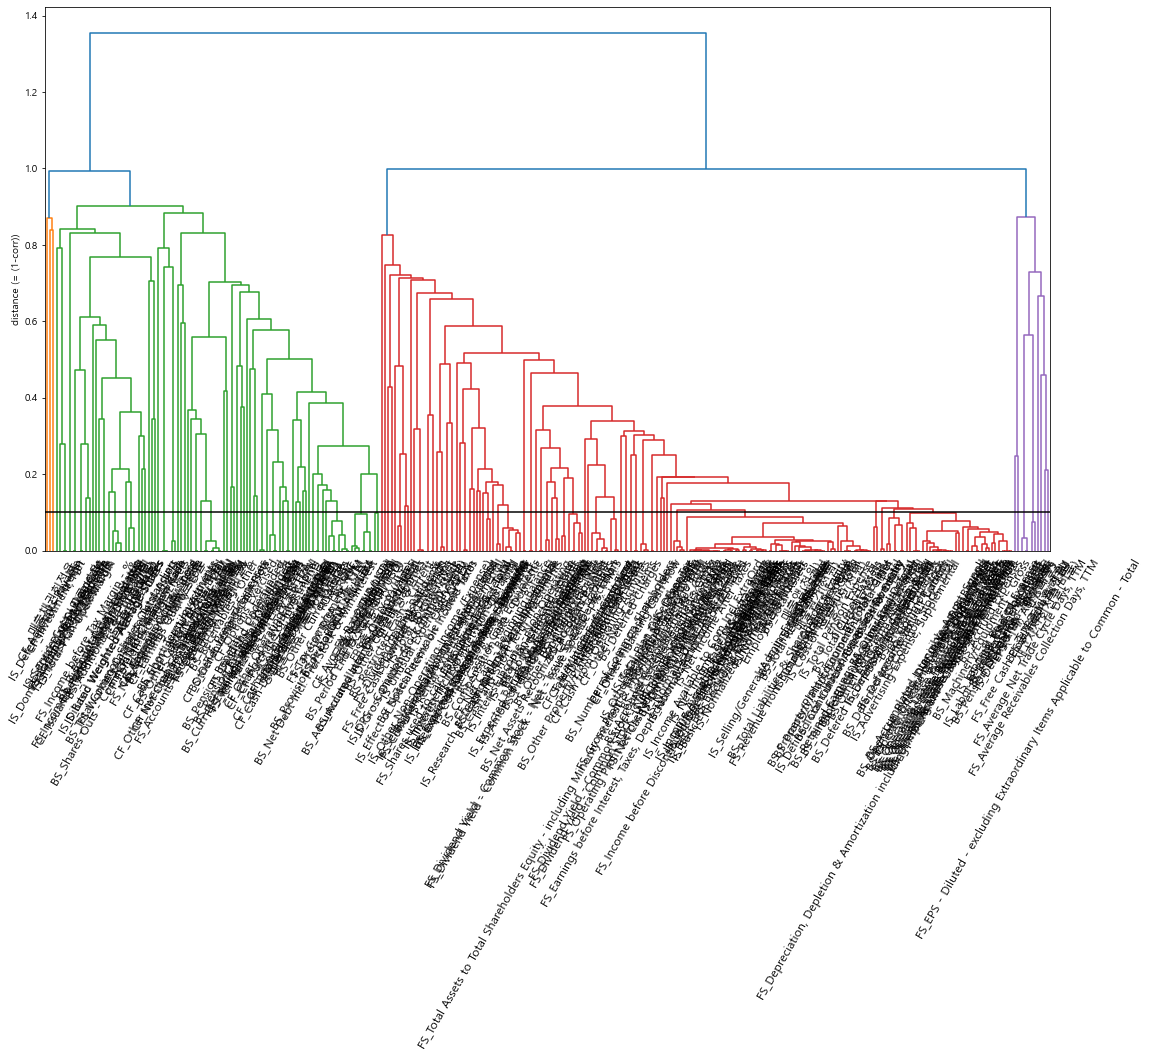

In [41]:
distance = 1 - df[col].corr()   
distance.mask(distance<0, 0, inplace=True)
# 0 <= distance <= 2
# distance = 0 이면 corr = 1
# distance = 2 이면 corr = -1

corr_condensed = hc.distance.squareform(distance)
z = hc.linkage(corr_condensed, method='average')

plt.figure(figsize=(18,10))
plt.ylabel('distance (= (1-corr))')
dendrogram = hc.dendrogram(z, labels=distance.columns, leaf_font_size=12, leaf_rotation=60)
plt.axhline(y=limit, c='k')
plt.show()

Text(0, 0.5, 'number of clusters')

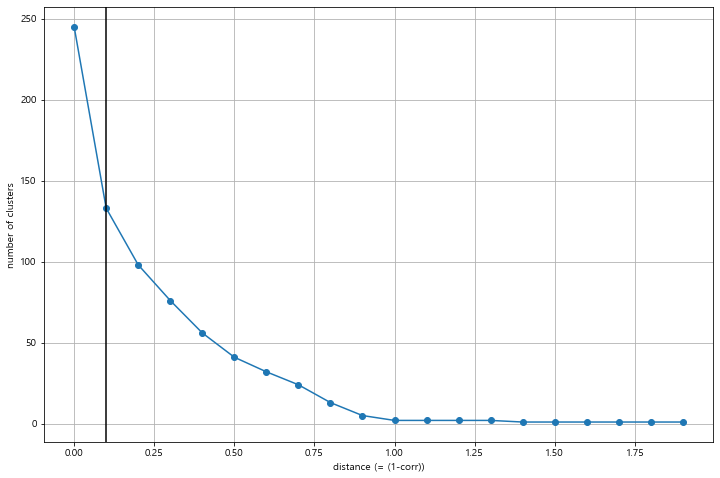

In [42]:
count = []
index = []
for i in np.arange(0, 2, 0.1):
    count.append(len(np.unique(hc.fcluster(z, t=i, criterion='distance'))))
    index.append(i)

plt.figure(figsize=(12,8))
plt.grid()
plt.plot(index, count, marker='o')
plt.axvline(limit, color='black')
plt.xlabel('distance (= (1-corr))')
plt.ylabel('number of clusters')

In [43]:
result = pd.DataFrame({'var':distance.columns, 'cluster':hc.fcluster(z, t=limit, criterion='distance')})
count_result = pd.DataFrame(pd.DataFrame(result['cluster'].value_counts()).reset_index())
count_result.columns = ['cluster', '# of variables']

In [44]:
print('Head : ')
display(count_result.head(10))
print('\nTail : ')
display(count_result.tail(10))

Head : 


,cluster,# of variables
0,115,57
1,120,33
2,63,7
3,59,7
4,90,6
5,33,6
6,119,6
7,102,6
8,100,5
9,114,4



Tail : 


,cluster,# of variables
123,38,1
124,66,1
125,30,1
126,22,1
127,21,1
128,6,1
129,24,1
130,50,1
131,28,1
132,57,1


### Plot scatter plot, correlation matrix

In [45]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

In [46]:
len((result.cluster.value_counts()>1)[(result.cluster.value_counts()>1)].index)

47

In [47]:
def correlation_matrix (result, master, df, m):
    n=m
    
    for i in (result.cluster.value_counts()>1)[(result.cluster.value_counts()>1)].index:
        tmp = df.loc[:,result[result.cluster==i]['var']]
        cluster_lot = tmp.columns
        split_cluster_lot = [cluster_lot[i * n:(i + 1) * n] for i in range((len(cluster_lot) + n - 1) // n )]
        
        print('\ncluster '+ str(i) + '\n' + '# of variable = ' + str(result.cluster.value_counts()[result.cluster.value_counts().index==i].values[0]))   
        print('\nDisplay the description of variables : ')
        
#         show = master[master.variable.isin(cluster_lot)].sort_values('importance', ascending=True)
        show = master[master.variable.isin(cluster_lot)]
        show = show.sort_values(['importance', 'group','variable'], ascending=[True, True, False])
        display(show)
        
        print('\nDisplay scatter & correlation plot per '+str(m)+' variables : ')
        for j in split_cluster_lot:
            tmp = df.loc[:,j]
            sns.set(style='white', font="Malgun Gothic", font_scale=1.8)
            g = sns.PairGrid(tmp, aspect=1.4, diag_sharey=False)
            # g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
            g.map_lower(sns.regplot, line_kws={'color': 'black'})
            g.map_diag(sns.distplot, kde_kws={'color': 'black'})
            g.map_upper(corrdot)
            plt.show()
            print('\n\n')
        print('==================================================================================================================')
        
    cluster_1 = (result.cluster.value_counts()>1)[~(result.cluster.value_counts()>1)].index
    split_cluster_1 = [cluster_1[i * n:(i + 1) * n] for i in range((len(cluster_1) + n - 1) // n )]

    for i in split_cluster_1:
        tmp = df.loc[:,result[result.cluster.isin(i)]['var']]

        print('\ncluster '+ str(list(i)) + '\n' + '# of variable = 1\n'+ 'not clustered')
        sns.set(style='white', font="Malgun Gothic", font_scale=1.8)
        g = sns.PairGrid(tmp, aspect=1.4, diag_sharey=False)
        # g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
        g.map_lower(sns.regplot, line_kws={'color': 'black'})
        g.map_diag(sns.distplot, kde_kws={'color': 'black'})
        g.map_upper(corrdot)
        plt.show()
        print('\n\n')
        print('==================================================================================================================')
        

In [48]:
# correlation_matrix(result, master, df, 8)

In [49]:
# x~x는 전체 기간에 대해서만 분석하고 있음

## feature selection

In [50]:
n=8
keep_lst = pd.DataFrame()
cnt_var = 0
cnt_g = 0
drops = 0

for i in (result.cluster.value_counts()>1)[(result.cluster.value_counts()>1)].index:
    cnt_g += 1
    tmp = df.loc[:,result[result.cluster==i]['var']]
    cluster_lot = tmp.columns
    split_cluster_lot = [cluster_lot[i * n:(i + 1) * n] for i in range((len(cluster_lot) + n - 1) // n )]

    print('\ncluster '+ str(i) + '\n' + '# of variable = ' + str(result.cluster.value_counts()[result.cluster.value_counts().index==i].values[0]))   
    cnt_var += result.cluster.value_counts()[result.cluster.value_counts().index==i].values[0]
    print('\nDisplay the description of variables : ')

    show = master[master.variable.isin(cluster_lot)]
    show['cluster'] = str(i)
    
#     show = show[show['group'].apply(lambda x: x.encode().isalpha()) == True]
    show = show.sort_values(['importance', 'group','variable'], ascending=[True, True, False]).reset_index(drop=True)
    
    # importance=0인 것 먼저 빼놓기
    cluster_lst = pd.DataFrame()
    cluster_lst = pd.concat([cluster_lst, show.loc[show['importance']==0,:]])
    
    # importance가 중요한거를 미리 빼놓고, group 기준으로 중복되는 항목 삭제
    show2 = show.loc[show['importance']==show['importance'].min(),:]
    show2.drop_duplicates('group', inplace=True, keep='first')
    show2.reset_index(drop=True, inplace=True)
    
    print("show::::")
    display(show)
    cluster_lst = pd.merge(cluster_lst, show2, how='outer', on=['raw','no','variable','group','importance','cluster'])
#     print("cluster_lst::::")
#     display(cluster_lst)
    eng = False
    for j in range(len(cluster_lst)):
        if cluster_lst.loc[j, 'group'].encode().isalpha() == True:
            eng = True
            
    if eng == True:
        cluster_lst = cluster_lst.head(1)
#     show2 = show2[show2['group'].apply(lambda x: (x.encode().isalpha()) == False)]
    drops += len(show) - len(cluster_lst)
    keep_lst = pd.concat([keep_lst, cluster_lst], axis=0)
    
    display(cluster_lst)


cluster 115
# of variable = 57

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,매출액(천원),297,매출액(천원),성장성,0,115
1,매출총이익(천원),299,매출총이익(천원),수익성,0,115
2,영업이익(천원),300,영업이익(천원),수익성,1,115
3,당기순이익(천원),296,당기순이익(천원),수익성,1,115
4,Employment Number,294,Employment Number,ET,2,115
5,매출원가(천원),298,매출원가(천원),성장성,2,115
6,이익잉여금(천원),310,이익잉여금(천원),수익성,2,115
7,SG&A,343,SG&A,수익성,2,115
8,자산총계(천원),312,자산총계(천원),안정성,2,115
9,유동자산(천원),309,유동자산(천원),안정성,2,115


,raw,no,variable,group,importance,cluster
0,매출액(천원),297,매출액(천원),성장성,0,115
1,매출총이익(천원),299,매출총이익(천원),수익성,0,115



cluster 120
# of variable = 33

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,Gross Investment (GI),348,Gross Investment (GI),성장성,2,120
1,자본금(천원),311,자본금(천원),안정성,2,120
2,비유동자산(천원),315,비유동자산(천원),안정성,2,120
3,부채총계(천원),308,부채총계(천원),안정성,2,120
4,BS_Total Plan Obligations,465,BS_Total Plan Obligations,BS,5,120
5,BS_Total Plan Assets,466,BS_Total Plan Assets,BS,5,120
6,"BS_Total Operating Leases, Supplemental",96,"BS_Total Operating Leases, Supplemental",BS,5,120
7,BS_Total Liabilities,54,BS_Total Liabilities,BS,5,120
8,BS_Total Current Liabilities,45,BS_Total Current Liabilities,BS,5,120
9,BS_Prepaid Expenses,355,BS_Prepaid Expenses,BS,5,120


,raw,no,variable,group,importance,cluster
0,Gross Investment (GI),348,Gross Investment (GI),성장성,2,120
1,자본금(천원),311,자본금(천원),안정성,2,120



cluster 63
# of variable = 7

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,유형자산감상비 누계,347,유형자산감상비 누계,안정성,1,63
1,무형자산감상비 누계,346,무형자산감상비 누계,안정성,1,63
2,BS_Period End FX Rate (INR/USD),448,BS_Period End FX Rate (INR/USD),BS,5,63
3,BS_Accumulated Intangible Amortization,28,BS_Accumulated Intangible Amortization,BS,5,63
4,"BS_Accumulated Depreciation, Total",24,"BS_Accumulated Depreciation, Total",BS,5,63
5,CF_Avg. FX Rate (INR/USD),467,CF_Avg. FX Rate (INR/USD),CF,5,63
6,IS_Avg. FX Rate (INR/USD),469,IS_Avg. FX Rate (INR/USD),IS,5,63


,raw,no,variable,group,importance,cluster
0,유형자산감상비 누계,347,유형자산감상비 누계,안정성,1,63



cluster 59
# of variable = 7

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,ROE(지배)(비율),329,ROE(지배)(비율),수익성,1,59
1,ROA(비율),328,ROA(비율),수익성,1,59
2,"Return on Invested Capital - %, TTM",264,FS_ROIC,FS,5,59
3,Return on Average Common Equity - % (Income av...,262,FS_ROE,FS,5,59
4,Return on Average Total Assets - % (Income bef...,263,FS_ROA,FS,5,59
5,"Pretax ROA - %, TTM",278,"FS_Pretax ROA - %, TTM",FS,5,59
6,"Pretax ROE - %, TTM",280,"FS_Pretax ROE - %, TTM",DL,9,59


,raw,no,variable,group,importance,cluster
0,ROE(지배)(비율),329,ROE(지배)(비율),수익성,1,59



cluster 90
# of variable = 6

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,단기투자자산,344,단기투자자산,안정성,1,90
1,BS_Cash and Short Term Investments,3,BS_Cash and Short Term Investments,BS,5,90
2,CF_Net Cash - Ending Balance,150,CF_Net Cash - Ending Balance,CF,5,90
3,CF_Net Cash - Beginning Balance,149,CF_Net Cash - Beginning Balance,CF,5,90
4,Cash & Short-Term Investments,240,FS_Cash & Short-Term Investments,FS,5,90
5,IS_Interest Income - Non-Operating,180,IS_Interest Income - Non-Operating,IS,5,90


,raw,no,variable,group,importance,cluster
0,단기투자자산,344,단기투자자산,안정성,1,90



cluster 33
# of variable = 6

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,매출액이익률(비율),323,매출액이익률(비율),수익성,0,33
1,EBITDA2마진율(비율),317,EBITDA2마진율(비율),수익성,1,33
2,영업이익률(비율),325,영업이익률(비율),수익성,2,33
3,Operating Margin - %,257,FS_Operating Margin - %,FS,5,33
4,Gross Profit Margin - %,255,FS_Gross Profit Margin - %,FS,5,33
5,EBITDA Margin - %,256,FS_EBITDA Margin - %,FS,5,33


,raw,no,variable,group,importance,cluster
0,매출액이익률(비율),323,매출액이익률(비율),수익성,0,33



cluster 119
# of variable = 6

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Deferred Revenue - Current,83,BS_Deferred Revenue - Current,BS,5,119
1,BS_Deferred Income Tax - LT Liability,51,BS_Deferred Income Tax - LT Liability,BS,5,119
2,BS_Deferred Income Tax,50,BS_Deferred Income Tax,BS,5,119
3,BS_Customer Advances,41,BS_Customer Advances,BS,5,119
4,"Depreciation, Depletion & Amortization includi...",245,"FS_Depreciation, Depletion & Amortization incl...",FS,5,119
5,"IS_Depreciation, Supplemental",221,"IS_Depreciation, Supplemental",IS,5,119


,raw,no,variable,group,importance,cluster
0,BS_Deferred Revenue - Current,83,BS_Deferred Revenue - Current,BS,5,119



cluster 102
# of variable = 6

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,Free Cash Flow2(천원),306,Free Cash Flow2(천원),수익성,0,102
1,CF_Net Income/Starting Line,108,CF_Net Income/Starting Line,CF,5,102
2,CF_Free Cash Flow,154,CF_Free Cash Flow,CF,5,102
3,CF_Depreciation/Depletion,109,CF_Depreciation/Depletion,CF,5,102
4,CF_Depreciation,110,CF_Depreciation,CF,5,102
5,CF_Cash from Operating Activities,121,CF_Cash from Operating Activities,CF,5,102


,raw,no,variable,group,importance,cluster
0,Free Cash Flow2(천원),306,Free Cash Flow2(천원),수익성,0,102



cluster 100
# of variable = 5

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,무형자산,339,무형자산,안정성,2,100
1,BS_Other Property/Plant/Equipment - Gross,22,BS_Other Property/Plant/Equipment - Gross,BS,5,100
2,"BS_Intangibles, Net",26,"BS_Intangibles, Net",BS,5,100
3,BS_Intangibles - Net,75,BS_Intangibles - Net,BS,5,100
4,BS_Accounts Payable,36,BS_Accounts Payable,BS,5,100


,raw,no,variable,group,importance,cluster
0,무형자산,339,무형자산,안정성,2,100



cluster 114
# of variable = 4

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Provision for Income Taxes,186,IS_Provision for Income Taxes,IS,5,114
1,IS_Other Tax,481,IS_Other Tax,IS,5,114
2,IS_Current Tax - Total,398,IS_Current Tax - Total,IS,5,114
3,IS_Inc Tax Ex Impact of Sp Items,216,IS_Inc Tax Ex Impact of Sp Items,DL,9,114


,raw,no,variable,group,importance,cluster
0,IS_Provision for Income Taxes,186,IS_Provision for Income Taxes,IS,5,114



cluster 13
# of variable = 4

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Total Common Shares Outstanding,68,BS_Total Common Shares Outstanding,BS,5,13
1,BS_Shares Outs - Common Stock Primary Issue,69,BS_Shares Outs - Common Stock Primary Issue,BS,5,13
2,IS_Diluted Weighted Average Shares,201,IS_Diluted Weighted Average Shares,IS,5,13
3,IS_Basic Weighted Average Shares,196,IS_Basic Weighted Average Shares,IS,5,13


,raw,no,variable,group,importance,cluster
0,BS_Total Common Shares Outstanding,68,BS_Total Common Shares Outstanding,BS,5,13



cluster 103
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,CF_Other Non-Cash Items,114,CF_Other Non-Cash Items,CF,5,103
1,CF_Non-Cash Items,112,CF_Non-Cash Items,CF,5,103
2,CF_Cash Taxes Paid,152,CF_Cash Taxes Paid,CF,5,103


,raw,no,variable,group,importance,cluster
0,CF_Other Non-Cash Items,114,CF_Other Non-Cash Items,CF,5,103



cluster 26
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Earnings Quality Score,2,BS_Earnings Quality Score,BS,5,26
1,CF_Earnings Quality Score,107,CF_Earnings Quality Score,CF,5,26
2,IS_Earnings Quality Score,155,IS_Earnings Quality Score,IS,5,26


,raw,no,variable,group,importance,cluster
0,BS_Earnings Quality Score,2,BS_Earnings Quality Score,BS,5,26



cluster 73
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Unusual Expense (Income),170,IS_Unusual Expense (Income),IS,5,73
1,IS_Effect of Special Items on Income Taxes,215,IS_Effect of Special Items on Income Taxes,IS,5,73
2,IS_Total Special Items,213,IS_Total Special Items,DL,9,73


,raw,no,variable,group,importance,cluster
0,IS_Unusual Expense (Income),170,IS_Unusual Expense (Income),IS,5,73



cluster 128
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"EPS(지배, Adj.)(원/주)",319,"EPS(지배, Adj.)(원/주)",수익성,2,128
1,"Free Cash Flow Yield - %, TTM",261,"FS_Free Cash Flow Yield - %, TTM",FS,5,128
2,EPS - Diluted - excluding Extraordinary Items ...,250,FS_EPS - Diluted - excluding Extraordinary Ite...,FS,5,128


,raw,no,variable,group,importance,cluster
0,"EPS(지배, Adj.)(원/주)",319,"EPS(지배, Adj.)(원/주)",수익성,2,128



cluster 15
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,유동비율(비율),335,유동비율(비율),안정성,2,15
1,Working Capital to Total Assets,286,FS_Working Capital to Total Assets,FS,5,15
2,Current Ratio,284,FS_Current Ratio,FS,5,15


,raw,no,variable,group,importance,cluster
0,유동비율(비율),335,유동비율(비율),안정성,2,15



cluster 48
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,운전자본증감(천원),301,운전자본증감(천원),안정성,2,48
1,CF_Other Operating Cash Flow,381,CF_Other Operating Cash Flow,CF,5,48
2,CF_Changes in Working Capital,115,CF_Changes in Working Capital,CF,5,48


,raw,no,variable,group,importance,cluster
0,운전자본증감(천원),301,운전자본증감(천원),안정성,2,48



cluster 110
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,Operating Profit before Non-Recurring Income/E...,236,FS_Operating Profit before Non-Recurring Incom...,FS,5,110
1,Gross Profit - Industrials/Property - Total,235,FS_Gross Profit - Industrials/Property - Total,FS,5,110
2,"Earnings before Interest, Taxes, Depreciation ...",237,"FS_Earnings before Interest, Taxes, Depreciati...",FS,5,110


,raw,no,variable,group,importance,cluster
0,Operating Profit before Non-Recurring Income/E...,236,FS_Operating Profit before Non-Recurring Incom...,FS,5,110



cluster 7
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Total Plan Interest Cost,495,IS_Total Plan Interest Cost,IS,5,7
1,IS_Interest Cost - Domestic,483,IS_Interest Cost - Domestic,IS,5,7


,raw,no,variable,group,importance,cluster
0,IS_Total Plan Interest Cost,495,IS_Total Plan Interest Cost,IS,5,7



cluster 118
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"BS_Other Equity, Total",62,"BS_Other Equity, Total",BS,5,118
1,BS_Other Equity,417,BS_Other Equity,BS,5,118


,raw,no,variable,group,importance,cluster
0,"BS_Other Equity, Total",62,"BS_Other Equity, Total",BS,5,118



cluster 81
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Interest/Invest Income - Non-Operating,179,IS_Interest/Invest Income - Non-Operating,IS,5,81
1,"IS_Interest Inc.(Exp.),Net-Non-Op., Total",182,"IS_Interest Inc.(Exp.),Net-Non-Op., Total",IS,5,81


,raw,no,variable,group,importance,cluster
0,IS_Interest/Invest Income - Non-Operating,179,IS_Interest/Invest Income - Non-Operating,IS,5,81



cluster 27
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"CF_Other Investing Cash Flow Items, Total",125,"CF_Other Investing Cash Flow Items, Total",CF,5,27
1,CF_Cash from Investing Activities,130,CF_Cash from Investing Activities,CF,5,27


,raw,no,variable,group,importance,cluster
0,"CF_Other Investing Cash Flow Items, Total",125,"CF_Other Investing Cash Flow Items, Total",CF,5,27



cluster 94
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Total Plan Expected Return,497,IS_Total Plan Expected Return,IS,5,94
1,IS_Expected Return on Assets - Domestic,486,IS_Expected Return on Assets - Domestic,IS,5,94


,raw,no,variable,group,importance,cluster
0,IS_Total Plan Expected Return,497,IS_Total Plan Expected Return,IS,5,94



cluster 47
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,CF_Purchase of Fixed Assets,123,CF_Purchase of Fixed Assets,CF,5,47
1,CF_Capital Expenditures,122,CF_Capital Expenditures,CF,5,47


,raw,no,variable,group,importance,cluster
0,CF_Purchase of Fixed Assets,123,CF_Purchase of Fixed Assets,CF,5,47



cluster 75
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"IS_Other, Net",183,"IS_Other, Net",IS,5,75
1,IS_Other Non-Operating Income (Expense),184,IS_Other Non-Operating Income (Expense),IS,5,75


,raw,no,variable,group,importance,cluster
0,"IS_Other, Net",183,"IS_Other, Net",IS,5,75



cluster 111
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Total Plan Other Expense,498,IS_Total Plan Other Expense,IS,5,111
1,"IS_Other Pension, Net - Domestic",489,"IS_Other Pension, Net - Domestic",IS,5,111


,raw,no,variable,group,importance,cluster
0,IS_Total Plan Other Expense,498,IS_Total Plan Other Expense,IS,5,111



cluster 99
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,부채비율(비율),307,부채비율(비율),안정성,0,99
1,Total Assets to Total Shareholders Equity - in...,279,FS_Total Assets to Total Shareholders Equity -...,FS,5,99


,raw,no,variable,group,importance,cluster
0,부채비율(비율),307,부채비율(비율),안정성,0,99



cluster 4
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Total Plan Service Cost,496,IS_Total Plan Service Cost,IS,5,4
1,IS_Service Cost - Domestic,485,IS_Service Cost - Domestic,IS,5,4


,raw,no,variable,group,importance,cluster
0,IS_Total Plan Service Cost,496,IS_Total Plan Service Cost,IS,5,4



cluster 49
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,CF_Total Cash Dividends Paid,133,CF_Total Cash Dividends Paid,CF,5,49
1,CF_Cash Dividends Paid - Common,134,CF_Cash Dividends Paid - Common,CF,5,49


,raw,no,variable,group,importance,cluster
0,CF_Total Cash Dividends Paid,133,CF_Total Cash Dividends Paid,CF,5,49



cluster 97
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Other Long Term Liabilities,53,BS_Other Long Term Liabilities,BS,5,97
1,"BS_Other Liabilities, Total",52,"BS_Other Liabilities, Total",BS,5,97


,raw,no,variable,group,importance,cluster
0,BS_Other Long Term Liabilities,53,BS_Other Long Term Liabilities,BS,5,97



cluster 79
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,CAPEX(천원),327,CAPEX(천원),성장성,1,79
1,Capital Expenditures - Net - Cash Flow,246,FS_CAPEX,FS,5,79


,raw,no,variable,group,importance,cluster
0,CAPEX(천원),327,CAPEX(천원),성장성,1,79



cluster 108
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,CF_Other Financing Cash Flow,132,CF_Other Financing Cash Flow,CF,5,108
1,CF_Financing Cash Flow Items,131,CF_Financing Cash Flow Items,CF,5,108


,raw,no,variable,group,importance,cluster
0,CF_Other Financing Cash Flow,132,CF_Other Financing Cash Flow,CF,5,108



cluster 106
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,Dividend Yield - Common Stock - Net - Issue Sp...,249,FS_Dividend Yield - Common Stock - Net - Issue...,FS,5,106
1,Dividend Yield - Common Stock - Net - Issue Sp...,249,FS_Dividend Yield - Common Stock - Net - Issue...,FS,5,106


,raw,no,variable,group,importance,cluster
0,Dividend Yield - Common Stock - Net - Issue Sp...,249,FS_Dividend Yield - Common Stock - Net - Issue...,FS,5,106



cluster 87
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"IS_Research & Development Exp, Supplemental",396,"IS_Research & Development Exp, Supplemental",IS,5,87
1,IS_Discount Rate - Domestic,492,IS_Discount Rate - Domestic,IS,5,87


,raw,no,variable,group,importance,cluster
0,"IS_Research & Development Exp, Supplemental",396,"IS_Research & Development Exp, Supplemental",IS,5,87



cluster 89
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Cash & Equivalents,4,BS_Cash & Equivalents,BS,5,89
1,Cash & Cash Equivalents,239,FS_Cash & Cash Equivalents,FS,5,89


,raw,no,variable,group,importance,cluster
0,BS_Cash & Equivalents,4,BS_Cash & Equivalents,BS,5,89



cluster 64
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,인당영업이익s,341,인당영업이익s,수익성,1,64
1,인당순이익s,342,인당순이익s,수익성,2,64


,raw,no,variable,group,importance,cluster
0,인당영업이익s,341,인당영업이익s,수익성,1,64



cluster 8
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,순이익률(비율),321,순이익률(비율),수익성,2,8
1,Net Margin - %,260,FS_Net Margin - %,FS,5,8


,raw,no,variable,group,importance,cluster
0,순이익률(비율),321,순이익률(비율),수익성,2,8



cluster 117
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"BS_Other Long Term Assets, Total",32,"BS_Other Long Term Assets, Total",BS,5,117
1,BS_Defered Income Tax - Long Term Asset,33,BS_Defered Income Tax - Long Term Asset,BS,5,117


,raw,no,variable,group,importance,cluster
0,"BS_Other Long Term Assets, Total",32,"BS_Other Long Term Assets, Total",BS,5,117



cluster 93
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,Dividend Yield - Common Stock - Net - Issue Sp...,249,FS_Dividend Yield - Common Stock - Net - Issue...,FS,5,93
1,Dividend Yield - Common Stock - Net - Issue Sp...,249,FS_Dividend Yield - Common Stock - Net - Issue...,FS,5,93


,raw,no,variable,group,importance,cluster
0,Dividend Yield - Common Stock - Net - Issue Sp...,249,FS_Dividend Yield - Common Stock - Net - Issue...,FS,5,93



cluster 69
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,현금배당성향(%),313,현금배당성향(%),수익성,1,69
1,Dividend Payout Ratio - %,272,FS_Dividend Payout Ratio - %,FS,5,69


,raw,no,variable,group,importance,cluster
0,현금배당성향(%),313,현금배당성향(%),수익성,1,69



cluster 32
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,총자산회전율(비율),336,총자산회전율(비율),활동성,0,32
1,"Asset Turnover, TTM",276,"FS_Asset Turnover, TTM",FS,5,32


,raw,no,variable,group,importance,cluster
0,총자산회전율(비율),336,총자산회전율(비율),활동성,0,32



cluster 11
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Total Funded Status,452,BS_Total Funded Status,BS,5,11
1,BS_Funded Status - Domestic,455,BS_Funded Status - Domestic,BS,5,11


,raw,no,variable,group,importance,cluster
0,BS_Total Funded Status,452,BS_Total Funded Status,BS,5,11



cluster 95
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Long Term Investments,29,BS_Long Term Investments,BS,5,95
1,BS_LT Investments - Other,31,BS_LT Investments - Other,BS,5,95


,raw,no,variable,group,importance,cluster
0,BS_Long Term Investments,29,BS_Long Term Investments,BS,5,95



cluster 96
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Prepaid Benefits - Domestic,460,BS_Prepaid Benefits - Domestic,BS,5,96
1,BS_Net Assets Recognized on Balance Sheet,459,BS_Net Assets Recognized on Balance Sheet,BS,5,96


,raw,no,variable,group,importance,cluster
0,BS_Prepaid Benefits - Domestic,460,BS_Prepaid Benefits - Domestic,BS,5,96



cluster 77
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,Shares used to calculate Diluted EPS - Total,251,FS_Shares used to calculate Diluted EPS - Total,FS,5,77
1,Common Shares - Outstanding - Total,265,FS_Common Shares - Outstanding - Total,FS,5,77


,raw,no,variable,group,importance,cluster
0,Shares used to calculate Diluted EPS - Total,251,FS_Shares used to calculate Diluted EPS - Total,FS,5,77



cluster 129
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"Average Receivables Collection Days, TTM",288,"FS_Average Receivables Collection Days, TTM",FS,5,129
1,"Average Net Trade Cycle Days, TTM",293,"FS_Average Net Trade Cycle Days, TTM",FS,5,129


,raw,no,variable,group,importance,cluster
0,"Average Receivables Collection Days, TTM",288,"FS_Average Receivables Collection Days, TTM",FS,5,129



cluster 58
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,순부채(천원),302,순부채(천원),안정성,2,58
1,BS_Net Debt Incl. Pref.Stock & Min.Interest,94,BS_Net Debt Incl. Pref.Stock & Min.Interest,BS,5,58


,raw,no,variable,group,importance,cluster
0,순부채(천원),302,순부채(천원),안정성,2,58


In [51]:
drops

171

In [52]:
C = ['매출액증가율(YoY)(연도)', 'Gross Investment (GI)','무형자산회전율s','매출총이익(천원)','무형자산'] 

In [53]:
for c in C:
    if c not in keep_lst['variable'].values:
        print(c)

매출액증가율(YoY)(연도)
무형자산회전율s


In [54]:
cluster_one = result.cluster.value_counts()[result.cluster.value_counts()==1].index
cluster_one = result[result['cluster'].apply(lambda x: x in cluster_one)]
"무형자산회전율s" in cluster_one['var'].values

True

In [55]:
# 남은 컬럼수
len(keep_lst)+len(cluster_one)

135

In [56]:
print(len(cluster_one))
cluster_one

86


,var,cluster
0,"BPS(지배, Adj.)(원/주)",55
1,BPS증가율(YoY)(비율),133
3,"BS_Accounts Receivable - Trade, Gross",112
9,BS_Additional Paid-In Capital,14
15,BS_Compensation Rate - Domestic,91
...,...,...
295,인당매출s,132
298,자기자본비율,16
301,재고자산회전율(비율),131
303,투자비 대비 매출 (Rev/GI)s,18


In [57]:
# 남는 column 저장
final_cols = keep_lst['variable'].values.tolist() + cluster_one['var'].values.tolist() 


In [58]:
dic_cluster = dict(result.values)

In [59]:
# 남는 column들 클러스터 정보 붙이기
final_cols = pd.DataFrame({'cols':final_cols})
final_cols['cluster'] = final_cols['cols'].map(dic_cluster)
final_cols

,cols,cluster
0,매출액(천원),115
1,매출총이익(천원),115
2,Gross Investment (GI),120
3,자본금(천원),120
4,유형자산감상비 누계,63
...,...,...
130,인당매출s,132
131,자기자본비율,16
132,재고자산회전율(비율),131
133,투자비 대비 매출 (Rev/GI)s,18


In [60]:
# 전체 원래 컬럼들의 distance 정보 붙이기
tt = distance['EV_EBITDA'].to_frame().reset_index()
tt.columns = ['cols','distance']
tt

,cols,distance
0,"BPS(지배, Adj.)(원/주)",0.286872
1,BPS증가율(YoY)(비율),0.658828
2,BS_Accounts Payable,0.895913
3,"BS_Accounts Receivable - Trade, Gross",1.278165
4,"BS_Accounts Receivable - Trade, Net",1.165532
...,...,...
301,재고자산회전율(비율),0.337686
302,총자산회전율(비율),1.021509
303,투자비 대비 매출 (Rev/GI)s,1.331560
304,현금배당성향(%),0.931166


In [61]:
# 남는 컬럼들의 클러스터와 거리 정보 합치기
final_cols = pd.merge(final_cols,tt, how='left', left_on='cols', right_on='cols')
final_cols

,cols,cluster,distance
0,매출액(천원),115,1.282983
1,매출총이익(천원),115,1.339558
2,Gross Investment (GI),120,1.224794
3,자본금(천원),120,1.117230
4,유형자산감상비 누계,63,0.802545
...,...,...,...
130,인당매출s,132,0.666179
131,자기자본비율,16,1.196226
132,재고자산회전율(비율),131,0.337686
133,투자비 대비 매출 (Rev/GI)s,18,1.331560


In [62]:
final_cols.to_csv(os.path.join(dir_result,raw_file_name.split('_')[0]+'_final_cols.csv'), index=False)

In [63]:
master_ = master[master.variable.isin(df.columns.values.tolist())]

drop = result[result.apply(lambda x: x['var'] not in final_cols['cols'].values.tolist(), axis=1)].reset_index(drop=True)
drop = master_[master_.variable.isin(drop['var'].values.tolist())]
drop.reset_index(drop=True, inplace=True)
drop
drop.to_excel(os.path.join(dir_result, raw_file_name.split('_')[0]+'_clustering_dropcols.xlsx'), index=False)

In [64]:
set(final_cols['cols'])&set(drop['variable'])

set()

In [65]:
result[result.apply(lambda x: 'Dividend Yield - Common Stock - Net - Issue Specific - %' in x['var'], axis=1)]['var'].values

array(['FS_Dividend Yield - Common Stock - Net - Issue Specific - %, TTM',
       'FS_Dividend Yield - Common Stock - Net - Issue Specific - %, TTM.1',
       'FS_Dividend Yield - Common Stock - Net - Issue Specific - %, TTM.2',
       'FS_Dividend Yield - Common Stock - Net - Issue Specific - %, TTM.3'],
      dtype=object)

In [66]:
print(len(set(final_cols.cols)))
print(len(set(df.columns)-set(drop.variable)))
print((set(df.columns)-set(drop.variable)) - set(final_cols.cols))


135
136
{'Date_x'}


# TCS

## Load data

In [67]:
raw_file_name = "TCS_non_shift_clean_total_v1.1.csv"

In [68]:
# df = pd.read_excel(os.path.join(dir_processed, 'ACN.xlsx'))
# df = pd.read_csv(os.path.join(dir_processed, 'clean_data_with_y1y2.csv'))
# df = pd.read_csv(os.path.join(dir_processed, raw_file_name)) 
df = pd.read_csv(os.path.join(dir_processed, raw_file_name))


# read_excel -> read_csv 변경
# C:\Users\10188\Desktop\기업가치\clean_data


# master = pd.read_excel(os.path.join(dir_master, '해외기업 재무index 분류(Master)_0614.xlsx'))
# master = pd.read_excel(os.path.join(dir_master, 'Accenture_Handwork.xlsx'), sheet_name='Desc')
master = pd.read_excel(os.path.join(dir_master, 'desc_v2.2.xlsx'), sheet_name='desc')

In [69]:
df['Date_x'] = pd.to_datetime(df['Date_x'])
# df['Date_quarter'] = pd.to_datetime(df['Date_quarter'])
# df = df.drop('Unnamed: 0', axis=1)
master = master.drop('Unnamed: 0', axis=1)
master = master.iloc[:,:5]
# master.columns = master.iloc[0,:]
# master = master.drop(0, axis=0).reset_index(drop=True)

# del df['DPS-Common-Net-Issue-ByAnnouncementDate1']
# df['Date_quarter'] = pd.to_datetime(df['Date_quarter'])
# df = df.drop('Unnamed: 0', axis=1)
# master.columns = master.iloc[0,:]
# master = master.drop(0, axis=0).reset_index(drop=True)


In [70]:
df.shape

(62, 319)

In [71]:
master

,raw,no,variable,group,importance
0,Date_x,1,Date_x,DT,9
1,BS_Earnings Quality Score,2,BS_Earnings Quality Score,BS,5
2,BS_Cash and Short Term Investments,3,BS_Cash and Short Term Investments,BS,5
3,BS_Cash & Equivalents,4,BS_Cash & Equivalents,BS,5
4,BS_Short Term Investments,5,BS_Short Term Investments,BS,5
...,...,...,...,...,...
557,Y4,558,EV_EBITDA,YY,9
558,"BS_Non-Current Marketable Securities,Suppl.",559,"BS_Non-Current Marketable Securities,Suppl.",BS,5
559,BS_Payable/Accrued,560,BS_Payable/Accrued,BS,5
560,BS_Wgt Avg Rem Lease Term (Yrs)-Fin Lease,561,BS_Wgt Avg Rem Lease Term (Yrs)-Fin Lease,BS,5


In [72]:
print(master.shape)
master.loc[len(master)] = ['IS_Other, Net.1', 183, 'IS_Other, Net.1','IS',5]
master.loc[len(master)] = ['IS_Current Tax - Total.1', 398, 'IS_Current Tax - Total.1','IS',5]
master.loc[len(master)] = ['IS_Deferred Tax - Total.1', 400, 'IS_Deferred Tax - Total.1','IS',5]
print(master.shape)

(562, 5)
(565, 5)


## Correlation X~X

In [73]:
# x값이 300개 이상일 때는 변수 먼저 제거 후 dendrogram 그리는 것도 괜찮은 방법

In [74]:
date = 'Date_x'
y1 = 'close'
y2 = 'close_weighted'
y3 = 'PBR'
y4 = 'EV_EBITDA'

col = [x for x in df.columns if (x not in [date, y1, y2, y3])]
# col = [x for x in df.columns if (x not in [date, y, 'Close_weighted'])]
# limit = 0.1
limit = 0.1

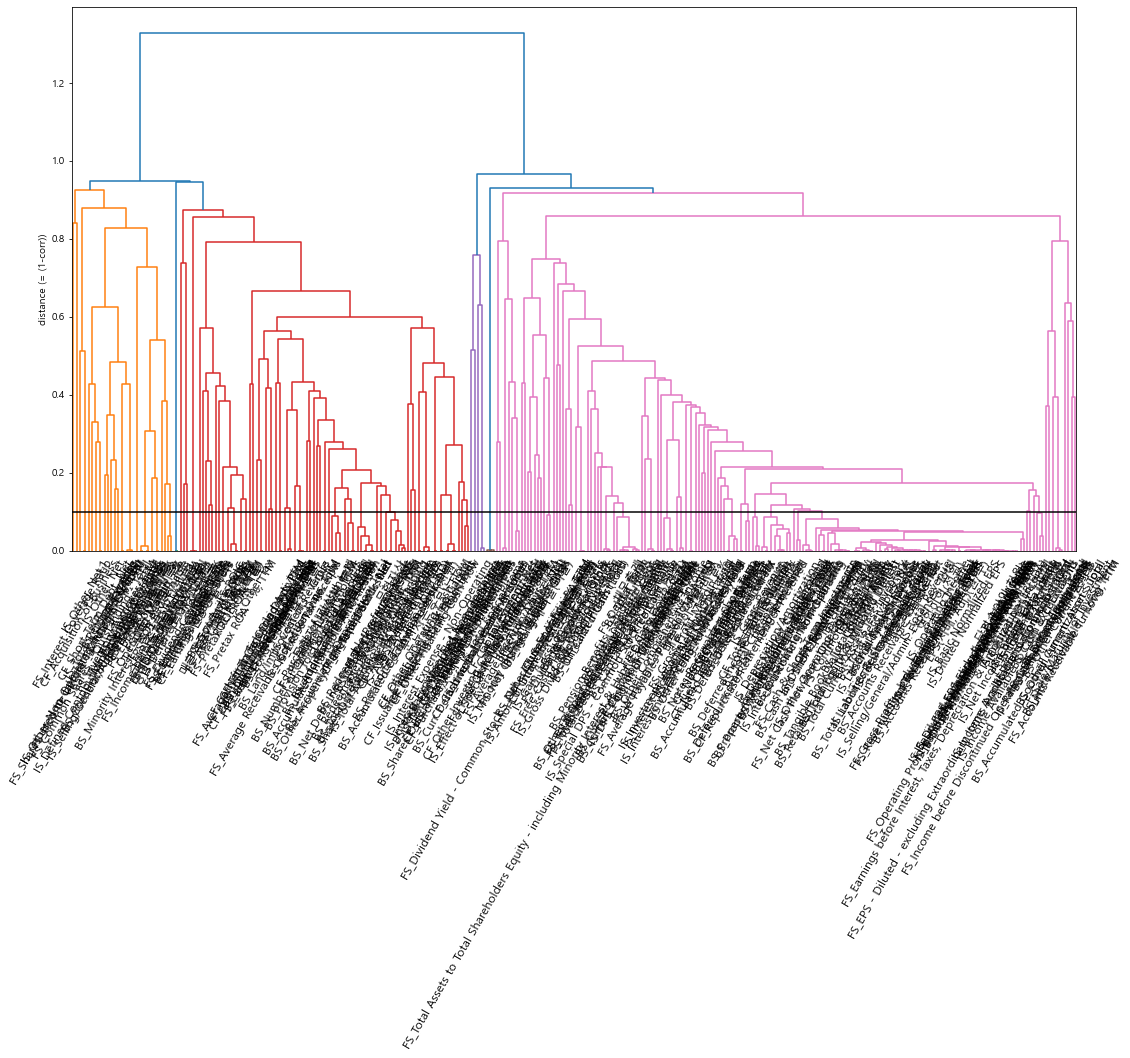

In [75]:
distance = 1 - df[col].corr()   
distance.mask(distance<0, 0, inplace=True)
# 0 <= distance <= 2
# distance = 0 이면 corr = 1
# distance = 2 이면 corr = -1

corr_condensed = hc.distance.squareform(distance)
z = hc.linkage(corr_condensed, method='average')

plt.figure(figsize=(18,10))
plt.ylabel('distance (= (1-corr))')
dendrogram = hc.dendrogram(z, labels=distance.columns, leaf_font_size=12, leaf_rotation=60)
plt.axhline(y=limit, c='k')
plt.show()

Text(0, 0.5, 'number of clusters')

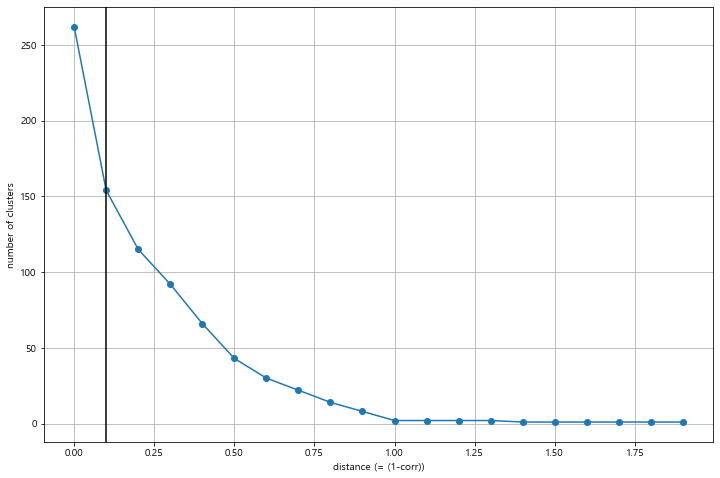

In [76]:
count = []
index = []
for i in np.arange(0, 2, 0.1):
    count.append(len(np.unique(hc.fcluster(z, t=i, criterion='distance'))))
    index.append(i)

plt.figure(figsize=(12,8))
plt.grid()
plt.plot(index, count, marker='o')
plt.axvline(limit, color='black')
plt.xlabel('distance (= (1-corr))')
plt.ylabel('number of clusters')

In [77]:
result = pd.DataFrame({'var':distance.columns, 'cluster':hc.fcluster(z, t=limit, criterion='distance')})
count_result = pd.DataFrame(pd.DataFrame(result['cluster'].value_counts()).reset_index())
count_result.columns = ['cluster', '# of variables']

In [78]:
print('Head : ')
display(count_result.head(10))
print('\nTail : ')
display(count_result.tail(10))

Head : 


,cluster,# of variables
0,131,71
1,129,10
2,106,8
3,63,7
4,61,6
5,74,4
6,116,4
7,16,4
8,58,4
9,122,4



Tail : 


,cluster,# of variables
144,88,1
145,79,1
146,43,1
147,115,1
148,110,1
149,4,1
150,111,1
151,136,1
152,89,1
153,92,1


### Plot scatter plot, correlation matrix

In [79]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

In [80]:
len((result.cluster.value_counts()>1)[(result.cluster.value_counts()>1)].index)

49

In [81]:
def correlation_matrix (result, master, df, m):
    n=m
    
    for i in (result.cluster.value_counts()>1)[(result.cluster.value_counts()>1)].index:
        tmp = df.loc[:,result[result.cluster==i]['var']]
        cluster_lot = tmp.columns
        split_cluster_lot = [cluster_lot[i * n:(i + 1) * n] for i in range((len(cluster_lot) + n - 1) // n )]
        
        print('\ncluster '+ str(i) + '\n' + '# of variable = ' + str(result.cluster.value_counts()[result.cluster.value_counts().index==i].values[0]))   
        print('\nDisplay the description of variables : ')
        
#         show = master[master.variable.isin(cluster_lot)].sort_values('importance', ascending=True)
        show = master[master.variable.isin(cluster_lot)]
        show = show.sort_values(['importance', 'group','variable'], ascending=[True, True, False])
        display(show)
        
        print('\nDisplay scatter & correlation plot per '+str(m)+' variables : ')
        for j in split_cluster_lot:
            tmp = df.loc[:,j]
            sns.set(style='white', font="Malgun Gothic", font_scale=1.8)
            g = sns.PairGrid(tmp, aspect=1.4, diag_sharey=False)
            # g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
            g.map_lower(sns.regplot, line_kws={'color': 'black'})
            g.map_diag(sns.distplot, kde_kws={'color': 'black'})
            g.map_upper(corrdot)
            plt.show()
            print('\n\n')
        print('==================================================================================================================')
        
    cluster_1 = (result.cluster.value_counts()>1)[~(result.cluster.value_counts()>1)].index
    split_cluster_1 = [cluster_1[i * n:(i + 1) * n] for i in range((len(cluster_1) + n - 1) // n )]

    for i in split_cluster_1:
        tmp = df.loc[:,result[result.cluster.isin(i)]['var']]

        print('\ncluster '+ str(list(i)) + '\n' + '# of variable = 1\n'+ 'not clustered')
        sns.set(style='white', font="Malgun Gothic", font_scale=1.8)
        g = sns.PairGrid(tmp, aspect=1.4, diag_sharey=False)
        # g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
        g.map_lower(sns.regplot, line_kws={'color': 'black'})
        g.map_diag(sns.distplot, kde_kws={'color': 'black'})
        g.map_upper(corrdot)
        plt.show()
        print('\n\n')
        print('==================================================================================================================')
        

In [82]:
# correlation_matrix(result, master, df, 8)

In [83]:
# x~x는 전체 기간에 대해서만 분석하고 있음

## feature selection

In [84]:
n=8
keep_lst = pd.DataFrame()
cnt_var = 0
cnt_g = 0
for i in (result.cluster.value_counts()>1)[(result.cluster.value_counts()>1)].index:
    cnt_g += 1
    tmp = df.loc[:,result[result.cluster==i]['var']]
    cluster_lot = tmp.columns
    split_cluster_lot = [cluster_lot[i * n:(i + 1) * n] for i in range((len(cluster_lot) + n - 1) // n )]

    print('\ncluster '+ str(i) + '\n' + '# of variable = ' + str(result.cluster.value_counts()[result.cluster.value_counts().index==i].values[0]))   
    cnt_var += result.cluster.value_counts()[result.cluster.value_counts().index==i].values[0]
    print('\nDisplay the description of variables : ')

    show = master[master.variable.isin(cluster_lot)]
    show['cluster'] = str(i)
    
#     show = show[show['group'].apply(lambda x: x.encode().isalpha()) == True]
    show = show.sort_values(['importance', 'group','variable'], ascending=[True, True, False]).reset_index(drop=True)
    
    # importance=0인 것 먼저 빼놓기
    cluster_lst = pd.DataFrame()
    cluster_lst = pd.concat([cluster_lst, show.loc[show['importance']==0,:]])
    
    # importance가 중요한거를 미리 빼놓고, group 기준으로 중복되는 항목 삭제
    show2 = show.loc[show['importance']==show['importance'].min(),:]
    show2.drop_duplicates('group', inplace=True, keep='first')
    show2.reset_index(drop=True, inplace=True)
    
    print("show::::")
    display(show[:10])
    cluster_lst = pd.merge(cluster_lst, show2, how='outer', on=['raw','no','variable','group','importance','cluster'])
#     print("cluster_lst::::")
#     display(cluster_lst)
    eng = False
    for j in range(len(cluster_lst)):
        if cluster_lst.loc[j, 'group'].encode().isalpha() == True:
            eng = True
            
    if eng == True:
        cluster_lst = cluster_lst.head(1)
#     show2 = show2[show2['group'].apply(lambda x: (x.encode().isalpha()) == False)]
 
    keep_lst = pd.concat([keep_lst, cluster_lst], axis=0)
    
    display(cluster_lst)


cluster 131
# of variable = 71

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,매출액(천원),297,매출액(천원),성장성,0,131
1,매출총이익(천원),299,매출총이익(천원),수익성,0,131
2,Opex Margin,352,Opex Margin,수익성,0,131
3,영업이익(천원),300,영업이익(천원),수익성,1,131
4,당기순이익(천원),296,당기순이익(천원),수익성,1,131
5,단기투자자산,344,단기투자자산,안정성,1,131
6,Employment Number,294,Employment Number,ET,2,131
7,Gross Investment (GI),348,Gross Investment (GI),성장성,2,131
8,이익잉여금(천원),310,이익잉여금(천원),수익성,2,131
9,SG&A,343,SG&A,수익성,2,131


,raw,no,variable,group,importance,cluster
0,매출액(천원),297,매출액(천원),성장성,0,131
1,매출총이익(천원),299,매출총이익(천원),수익성,0,131
2,Opex Margin,352,Opex Margin,수익성,0,131



cluster 129
# of variable = 10

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,부채총계(천원),308,부채총계(천원),안정성,2,129
1,BS_Total Liabilities,54,BS_Total Liabilities,BS,5,129
2,BS_Total Current Liabilities,45,BS_Total Current Liabilities,BS,5,129
3,"BS_Property/Plant/Equipment, Total - Net",23,"BS_Property/Plant/Equipment, Total - Net",BS,5,129
4,"BS_Property/Plant/Equipment, Total - Gross",17,"BS_Property/Plant/Equipment, Total - Gross",BS,5,129
5,BS_Machinery/Equipment - Gross,20,BS_Machinery/Equipment - Gross,BS,5,129
6,Market Capitalization,273,FS_Market Capitalization,FS,5,129
7,IS_Depreciation/Amortization,165,IS_Depreciation/Amortization,IS,5,129
8,"IS_Depreciation, Supplemental",221,"IS_Depreciation, Supplemental",IS,5,129
9,IS_Depreciation,166,IS_Depreciation,IS,5,129


,raw,no,variable,group,importance,cluster
0,부채총계(천원),308,부채총계(천원),안정성,2,129



cluster 106
# of variable = 8

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,채무총계,345,채무총계,안정성,1,106
1,BS_Total Long Term Debt,46,BS_Total Long Term Debt,BS,5,106
2,BS_Total Debt,49,BS_Total Debt,BS,5,106
3,BS_Current Port. of LT Debt/Capital Leases,39,BS_Current Port. of LT Debt/Capital Leases,BS,5,106
4,"BS_Curr. Port. of LT Capital Leases, Suppl.",85,"BS_Curr. Port. of LT Capital Leases, Suppl.",BS,5,106
5,BS_Capital Lease Obligations,48,BS_Capital Lease Obligations,BS,5,106
6,Debt - Total,242,FS_Debt - Total,FS,5,106
7,"IS_Interest Expense, Supplemental",222,"IS_Interest Expense, Supplemental",IS,5,106


,raw,no,variable,group,importance,cluster
0,채무총계,345,채무총계,안정성,1,106



cluster 63
# of variable = 7

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,무형자산,339,무형자산,안정성,2,63
1,BS_Period End FX Rate (INR/USD),448,BS_Period End FX Rate (INR/USD),BS,5,63
2,BS_Intangibles - Net,75,BS_Intangibles - Net,BS,5,63
3,BS_Accumulated Goodwill Amortization,523,BS_Accumulated Goodwill Amortization,BS,5,63
4,CF_Avg. FX Rate (INR/USD),467,CF_Avg. FX Rate (INR/USD),CF,5,63
5,"Tax Complement, TTM",281,"FS_Tax Complement, TTM",FS,5,63
6,IS_Avg. FX Rate (INR/USD),469,IS_Avg. FX Rate (INR/USD),IS,5,63


,raw,no,variable,group,importance,cluster
0,무형자산,339,무형자산,안정성,2,63



cluster 61
# of variable = 6

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Total Preferred Shares Outstanding,525,BS_Total Preferred Shares Outstanding,BS,5,61
1,BS_Shares Outstanding - Preferred Issue 1,526,BS_Shares Outstanding - Preferred Issue 1,BS,5,61
2,"BS_Redeemable Preferred Stock, Total",414,"BS_Redeemable Preferred Stock, Total",BS,5,61
3,BS_Redeemable Preferred Stock,415,BS_Redeemable Preferred Stock,BS,5,61
4,CF_Total Debt Issued,530,CF_Total Debt Issued,CF,5,61
5,"CF_Preferred Stock, Net",384,"CF_Preferred Stock, Net",CF,5,61


,raw,no,variable,group,importance,cluster
0,BS_Total Preferred Shares Outstanding,525,BS_Total Preferred Shares Outstanding,BS,5,61



cluster 74
# of variable = 4

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Total Common Shares Outstanding,68,BS_Total Common Shares Outstanding,BS,5,74
1,BS_Shares Outs - Common Stock Primary Issue,69,BS_Shares Outs - Common Stock Primary Issue,BS,5,74
2,IS_Diluted Weighted Average Shares,201,IS_Diluted Weighted Average Shares,IS,5,74
3,IS_Basic Weighted Average Shares,196,IS_Basic Weighted Average Shares,IS,5,74


,raw,no,variable,group,importance,cluster
0,BS_Total Common Shares Outstanding,68,BS_Total Common Shares Outstanding,BS,5,74



cluster 116
# of variable = 4

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,유동비율(비율),335,유동비율(비율),안정성,2,116
1,Working Capital to Total Assets,286,FS_Working Capital to Total Assets,FS,5,116
2,Quick Ratio,285,FS_Quick Ratio,FS,5,116
3,Current Ratio,284,FS_Current Ratio,FS,5,116


,raw,no,variable,group,importance,cluster
0,유동비율(비율),335,유동비율(비율),안정성,2,116



cluster 16
# of variable = 4

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,EBITDA2마진율(비율),317,EBITDA2마진율(비율),수익성,1,16
1,영업이익률(비율),325,영업이익률(비율),수익성,2,16
2,Operating Margin - %,257,FS_Operating Margin - %,FS,5,16
3,EBITDA Margin - %,256,FS_EBITDA Margin - %,FS,5,16


,raw,no,variable,group,importance,cluster
0,EBITDA2마진율(비율),317,EBITDA2마진율(비율),수익성,1,16



cluster 58
# of variable = 4

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,유형자산감상비 누계,347,유형자산감상비 누계,안정성,1,58
1,BS_Other Property/Plant/Equipment - Net,74,BS_Other Property/Plant/Equipment - Net,BS,5,58
2,BS_Additional Paid-In Capital,59,BS_Additional Paid-In Capital,BS,5,58
3,"BS_Accumulated Depreciation, Total",24,"BS_Accumulated Depreciation, Total",BS,5,58


,raw,no,variable,group,importance,cluster
0,유형자산감상비 누계,347,유형자산감상비 누계,안정성,1,58



cluster 122
# of variable = 4

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,무형자산회전율s,340,무형자산회전율s,활동성,0,122
1,BS_Deferred Revenue - Current,83,BS_Deferred Revenue - Current,BS,5,122
2,BS_Customer Advances,41,BS_Customer Advances,BS,5,122
3,BS_Accrued Expenses,37,BS_Accrued Expenses,BS,5,122


,raw,no,variable,group,importance,cluster
0,무형자산회전율s,340,무형자산회전율s,활동성,0,122



cluster 51
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,매출원가(천원),298,매출원가(천원),성장성,2,51
1,"IS_Cost of Revenue, Total",159,"IS_Cost of Revenue, Total",IS,5,51
2,IS_Cost of Revenue,160,IS_Cost of Revenue,IS,5,51


,raw,no,variable,group,importance,cluster
0,매출원가(천원),298,매출원가(천원),성장성,2,51



cluster 33
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,ROE(지배)(비율),329,ROE(지배)(비율),수익성,1,33
1,"Return on Invested Capital - %, TTM",264,FS_ROIC,FS,5,33
2,Return on Average Common Equity - % (Income av...,262,FS_ROE,FS,5,33


,raw,no,variable,group,importance,cluster
0,ROE(지배)(비율),329,ROE(지배)(비율),수익성,1,33



cluster 27
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Earnings Quality Score,2,BS_Earnings Quality Score,BS,5,27
1,CF_Earnings Quality Score,107,CF_Earnings Quality Score,CF,5,27
2,IS_Earnings Quality Score,155,IS_Earnings Quality Score,IS,5,27


,raw,no,variable,group,importance,cluster
0,BS_Earnings Quality Score,2,BS_Earnings Quality Score,BS,5,27



cluster 82
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Unusual Expense (Income),170,IS_Unusual Expense (Income),IS,5,82
1,IS_Effect of Special Items on Income Taxes,215,IS_Effect of Special Items on Income Taxes,IS,5,82
2,IS_Total Special Items,213,IS_Total Special Items,DL,9,82


,raw,no,variable,group,importance,cluster
0,IS_Unusual Expense (Income),170,IS_Unusual Expense (Income),IS,5,82



cluster 149
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"BS_Other Equity, Total",62,"BS_Other Equity, Total",BS,5,149
1,"BS_Other Current Assets, Total",12,"BS_Other Current Assets, Total",BS,5,149
2,BS_Other Current Assets,15,BS_Other Current Assets,BS,5,149


,raw,no,variable,group,importance,cluster
0,"BS_Other Equity, Total",62,"BS_Other Equity, Total",BS,5,149



cluster 71
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,운전자본증감(천원),301,운전자본증감(천원),안정성,2,71
1,CF_Other Operating Cash Flow,381,CF_Other Operating Cash Flow,CF,5,71
2,CF_Changes in Working Capital,115,CF_Changes in Working Capital,CF,5,71


,raw,no,variable,group,importance,cluster
0,운전자본증감(천원),301,운전자본증감(천원),안정성,2,71



cluster 15
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Minority Interest - Non Redeemable,418,BS_Minority Interest - Non Redeemable,BS,5,15
1,BS_Minority Interest,412,BS_Minority Interest,BS,5,15
2,Minority Interest - Total,447,Minority Interest - Total,ET,5,15


,raw,no,variable,group,importance,cluster
0,BS_Minority Interest - Non Redeemable,418,BS_Minority Interest - Non Redeemable,BS,5,15



cluster 105
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,Total Debt Percentage of Total Equity,268,FS_Total Debt Percentage of Total Equity,FS,5,105
1,Total Debt Percentage of Total Capital,267,FS_Total Debt Percentage of Total Capital,FS,5,105
2,Total Debt Percentage of Total Assets,266,FS_Total Debt Percentage of Total Assets,FS,5,105


,raw,no,variable,group,importance,cluster
0,Total Debt Percentage of Total Equity,268,FS_Total Debt Percentage of Total Equity,FS,5,105



cluster 128
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,CF_Total Debt Reduction,145,CF_Total Debt Reduction,CF,5,128
1,CF_Repurchase/Retirement of Preferred,383,CF_Repurchase/Retirement of Preferred,CF,5,128
2,IS_Gross Revenue,531,IS_Gross Revenue,IS,5,128


,raw,no,variable,group,importance,cluster
0,CF_Total Debt Reduction,145,CF_Total Debt Reduction,CF,5,128



cluster 59
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,순부채(천원),302,순부채(천원),안정성,2,59
1,비유동비율(천원),314,비유동비율(천원),안정성,2,59
2,BS_Net Debt Incl. Pref.Stock & Min.Interest,94,BS_Net Debt Incl. Pref.Stock & Min.Interest,BS,5,59


,raw,no,variable,group,importance,cluster
0,순부채(천원),302,순부채(천원),안정성,2,59



cluster 113
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,Free Cash Flow2(천원),306,Free Cash Flow2(천원),수익성,0,113
1,CF_Free Cash Flow,154,CF_Free Cash Flow,CF,5,113
2,CF_Cash from Operating Activities,121,CF_Cash from Operating Activities,CF,5,113


,raw,no,variable,group,importance,cluster
0,Free Cash Flow2(천원),306,Free Cash Flow2(천원),수익성,0,113



cluster 135
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,비유동자산(천원),315,비유동자산(천원),안정성,2,135
1,BS_Accumulated Goodwill Amortization Suppl.,528,BS_Accumulated Goodwill Amortization Suppl.,BS,5,135
2,"IS_Rental Expense, Supplemental",223,"IS_Rental Expense, Supplemental",IS,5,135


,raw,no,variable,group,importance,cluster
0,비유동자산(천원),315,비유동자산(천원),안정성,2,135



cluster 103
# of variable = 3

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,자본금(천원),311,자본금(천원),안정성,2,103
1,"BS_Common Stock, Total",57,"BS_Common Stock, Total",BS,5,103
2,BS_Common Stock,58,BS_Common Stock,BS,5,103


,raw,no,variable,group,importance,cluster
0,자본금(천원),311,자본금(천원),안정성,2,103



cluster 130
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Other Long Term Liabilities,53,BS_Other Long Term Liabilities,BS,5,130
1,"BS_Other Liabilities, Total",52,"BS_Other Liabilities, Total",BS,5,130


,raw,no,variable,group,importance,cluster
0,BS_Other Long Term Liabilities,53,BS_Other Long Term Liabilities,BS,5,130



cluster 49
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"BS_Goodwill, Net",25,"BS_Goodwill, Net",BS,5,49
1,BS_Goodwill - Net,76,BS_Goodwill - Net,BS,5,49


,raw,no,variable,group,importance,cluster
0,"BS_Goodwill, Net",25,"BS_Goodwill, Net",BS,5,49



cluster 75
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"CF_Long Term Debt, Net",144,"CF_Long Term Debt, Net",CF,5,75
1,CF_Long Term Debt Reduction,143,CF_Long Term Debt Reduction,CF,5,75


,raw,no,variable,group,importance,cluster
0,"CF_Long Term Debt, Net",144,"CF_Long Term Debt, Net",CF,5,75



cluster 5
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Total Pension Expense,490,IS_Total Pension Expense,IS,5,5
1,IS_Defined Contribution Expense - Domestic,491,IS_Defined Contribution Expense - Domestic,IS,5,5


,raw,no,variable,group,importance,cluster
0,IS_Total Pension Expense,490,IS_Total Pension Expense,IS,5,5



cluster 23
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Deferred Tax - Total.1,400,IS_Deferred Tax - Total.1,IS,5,23
1,IS_Deferred Tax - Total,400,IS_Deferred Tax - Total,IS,5,23


,raw,no,variable,group,importance,cluster
0,IS_Deferred Tax - Total.1,400,IS_Deferred Tax - Total.1,IS,5,23



cluster 57
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,무형자산감상비 누계,346,무형자산감상비 누계,안정성,1,57
1,BS_Accumulated Intangible Amortization,28,BS_Accumulated Intangible Amortization,BS,5,57


,raw,no,variable,group,importance,cluster
0,무형자산감상비 누계,346,무형자산감상비 누계,안정성,1,57



cluster 35
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,ROA(비율),328,ROA(비율),수익성,1,35
1,Return on Average Total Assets - % (Income bef...,263,FS_ROA,FS,5,35


,raw,no,variable,group,importance,cluster
0,ROA(비율),328,ROA(비율),수익성,1,35



cluster 19
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,영업이익증가율(YoY)(연도),326,영업이익증가율(YoY)(연도),성장성,1,19
1,EBITDA2증가율(YoY)(비율),318,EBITDA2증가율(YoY)(비율),성장성,1,19


,raw,no,variable,group,importance,cluster
0,영업이익증가율(YoY)(연도),326,영업이익증가율(YoY)(연도),성장성,1,19



cluster 14
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,CAPEX(천원),327,CAPEX(천원),성장성,1,14
1,Capital Expenditures - Net - Cash Flow,246,FS_CAPEX,FS,5,14


,raw,no,variable,group,importance,cluster
0,CAPEX(천원),327,CAPEX(천원),성장성,1,14



cluster 85
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,CF_Purchase of Fixed Assets,123,CF_Purchase of Fixed Assets,CF,5,85
1,CF_Capital Expenditures,122,CF_Capital Expenditures,CF,5,85


,raw,no,variable,group,importance,cluster
0,CF_Purchase of Fixed Assets,123,CF_Purchase of Fixed Assets,CF,5,85



cluster 42
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,CF_Total Cash Dividends Paid,133,CF_Total Cash Dividends Paid,CF,5,42
1,CF_Cash Dividends Paid - Common,134,CF_Cash Dividends Paid - Common,CF,5,42


,raw,no,variable,group,importance,cluster
0,CF_Total Cash Dividends Paid,133,CF_Total Cash Dividends Paid,CF,5,42



cluster 96
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,부채비율(비율),307,부채비율(비율),안정성,0,96
1,Total Assets to Total Shareholders Equity - in...,279,FS_Total Assets to Total Shareholders Equity -...,FS,5,96


,raw,no,variable,group,importance,cluster
0,부채비율(비율),307,부채비율(비율),안정성,0,96



cluster 72
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,CF_Other Financing Cash Flow,132,CF_Other Financing Cash Flow,CF,5,72
1,CF_Financing Cash Flow Items,131,CF_Financing Cash Flow Items,CF,5,72


,raw,no,variable,group,importance,cluster
0,CF_Other Financing Cash Flow,132,CF_Other Financing Cash Flow,CF,5,72



cluster 70
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"CF_Issuance (Retirement) of Stock, Net",135,"CF_Issuance (Retirement) of Stock, Net",CF,5,70
1,"CF_Common Stock, Net",137,"CF_Common Stock, Net",CF,5,70


,raw,no,variable,group,importance,cluster
0,"CF_Issuance (Retirement) of Stock, Net",135,"CF_Issuance (Retirement) of Stock, Net",CF,5,70



cluster 80
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"CF_Other Investing Cash Flow Items, Total",125,"CF_Other Investing Cash Flow Items, Total",CF,5,80
1,CF_Cash from Investing Activities,130,CF_Cash from Investing Activities,CF,5,80


,raw,no,variable,group,importance,cluster
0,"CF_Other Investing Cash Flow Items, Total",125,"CF_Other Investing Cash Flow Items, Total",CF,5,80



cluster 117
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Interest/Invest Income - Non-Operating,179,IS_Interest/Invest Income - Non-Operating,IS,5,117
1,"IS_Interest Inc.(Exp.),Net-Non-Op., Total",182,"IS_Interest Inc.(Exp.),Net-Non-Op., Total",IS,5,117


,raw,no,variable,group,importance,cluster
0,IS_Interest/Invest Income - Non-Operating,179,IS_Interest/Invest Income - Non-Operating,IS,5,117



cluster 73
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"IS_Interest Expense, Net Non-Operating",177,"IS_Interest Expense, Net Non-Operating",IS,5,73
1,IS_Interest Expense - Non-Operating,178,IS_Interest Expense - Non-Operating,IS,5,73


,raw,no,variable,group,importance,cluster
0,"IS_Interest Expense, Net Non-Operating",177,"IS_Interest Expense, Net Non-Operating",IS,5,73



cluster 17
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,순이익률(비율),321,순이익률(비율),수익성,2,17
1,Net Margin - %,260,FS_Net Margin - %,FS,5,17


,raw,no,variable,group,importance,cluster
0,순이익률(비율),321,순이익률(비율),수익성,2,17



cluster 86
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"IS_Minority Interest, Supplemental",226,"IS_Minority Interest, Supplemental",IS,5,86
1,IS_Minority Interest,188,IS_Minority Interest,IS,5,86


,raw,no,variable,group,importance,cluster
0,"IS_Minority Interest, Supplemental",226,"IS_Minority Interest, Supplemental",IS,5,86



cluster 32
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,총자산회전율(비율),336,총자산회전율(비율),활동성,0,32
1,"Asset Turnover, TTM",276,"FS_Asset Turnover, TTM",FS,5,32


,raw,no,variable,group,importance,cluster
0,총자산회전율(비율),336,총자산회전율(비율),활동성,0,32



cluster 119
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,매출액이익률(비율),323,매출액이익률(비율),수익성,0,119
1,Gross Profit Margin - %,255,FS_Gross Profit Margin - %,FS,5,119


,raw,no,variable,group,importance,cluster
0,매출액이익률(비율),323,매출액이익률(비율),수익성,0,119



cluster 3
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,"IS_Other, Net.1",183,"IS_Other, Net.1",IS,5,3
1,IS_Other Non-Operating Income (Expense),184,IS_Other Non-Operating Income (Expense),IS,5,3


,raw,no,variable,group,importance,cluster
0,"IS_Other, Net.1",183,"IS_Other, Net.1",IS,5,3



cluster 126
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Deferred Income Tax - LT Liability,51,BS_Deferred Income Tax - LT Liability,BS,5,126
1,BS_Deferred Income Tax,50,BS_Deferred Income Tax,BS,5,126


,raw,no,variable,group,importance,cluster
0,BS_Deferred Income Tax - LT Liability,51,BS_Deferred Income Tax - LT Liability,BS,5,126



cluster 47
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Long Term Investments,29,BS_Long Term Investments,BS,5,47
1,BS_LT Investments - Other,31,BS_LT Investments - Other,BS,5,47


,raw,no,variable,group,importance,cluster
0,BS_Long Term Investments,29,BS_Long Term Investments,BS,5,47



cluster 62
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,IS_Total Adjustments to Net Income,474,IS_Total Adjustments to Net Income,IS,5,62
1,IS_Preferred Dividends,502,IS_Preferred Dividends,IS,5,62


,raw,no,variable,group,importance,cluster
0,IS_Total Adjustments to Net Income,474,IS_Total Adjustments to Net Income,IS,5,62



cluster 127
# of variable = 2

Display the description of variables : 
show::::


,raw,no,variable,group,importance,cluster
0,BS_Other Equity,417,BS_Other Equity,BS,5,127
1,BS_Defered Income Tax - Long Term Asset,33,BS_Defered Income Tax - Long Term Asset,BS,5,127


,raw,no,variable,group,importance,cluster
0,BS_Other Equity,417,BS_Other Equity,BS,5,127


In [85]:
C = ['매출액증가율(YoY)(연도)', 'Gross Investment (GI)','무형자산회전율s','매출총이익(천원)','무형자산'] 

In [86]:
for c in C:
    if c not in keep_lst['variable'].values:
        print(c)

매출액증가율(YoY)(연도)
Gross Investment (GI)


In [87]:
cluster_one = result.cluster.value_counts()[result.cluster.value_counts()==1].index
cluster_one = result[result['cluster'].apply(lambda x: x in cluster_one)]
"Gross Investment (GI)" in cluster_one['var'].values

False

In [88]:
# 남은 컬럼수
len(keep_lst)+len(cluster_one)

156

In [89]:
print(len(cluster_one))
cluster_one

105


,var,cluster
0,"BPS(지배, Adj.)(원/주)",91
1,BPS증가율(YoY)(비율),22
2,BS_Accounts Payable,137
9,"BS_Accumulated Intangible Amort, Suppl.",138
14,BS_Cash,142
...,...,...
309,자기자본비율,152
312,재고자산회전율(비율),60
315,투자비 대비 매출 (Rev/GI)s,121
316,현금배당성향(%),101


In [90]:
# 남는 column 저장
final_cols = keep_lst['variable'].values.tolist() + cluster_one['var'].values.tolist() + ['Gross Investment (GI)']
final_cols

['매출액(천원)',
 '매출총이익(천원)',
 'Opex Margin',
 '부채총계(천원)',
 '채무총계',
 '무형자산',
 'BS_Total Preferred Shares Outstanding',
 'BS_Total Common Shares Outstanding',
 '유동비율(비율)',
 'EBITDA2마진율(비율)',
 '유형자산감상비 누계',
 '무형자산회전율s',
 '매출원가(천원)',
 'ROE(지배)(비율)',
 'BS_Earnings Quality Score',
 'IS_Unusual Expense (Income)',
 'BS_Other Equity, Total',
 '운전자본증감(천원)',
 'BS_Minority Interest - Non Redeemable',
 'FS_Total Debt Percentage of Total Equity',
 'CF_Total Debt Reduction',
 '순부채(천원)',
 'Free Cash Flow2(천원)',
 '비유동자산(천원)',
 '자본금(천원)',
 'BS_Other Long Term Liabilities',
 'BS_Goodwill, Net',
 'CF_Long Term Debt, Net',
 'IS_Total Pension Expense',
 'IS_Deferred Tax - Total.1',
 '무형자산감상비 누계',
 'ROA(비율)',
 '영업이익증가율(YoY)(연도)',
 'CAPEX(천원)',
 'CF_Purchase of Fixed Assets',
 'CF_Total Cash Dividends Paid',
 '부채비율(비율)',
 'CF_Other Financing Cash Flow',
 'CF_Issuance (Retirement) of Stock, Net',
 'CF_Other Investing Cash Flow Items, Total',
 'IS_Interest/Invest Income - Non-Operating',
 'IS_Interest Expense, Net

In [91]:
dic_cluster = dict(result.values)

In [92]:
# 남는 column들 클러스터 정보 붙이기
final_cols = pd.DataFrame({'cols':final_cols})
final_cols['cluster'] = final_cols['cols'].map(dic_cluster)
final_cols

,cols,cluster
0,매출액(천원),131
1,매출총이익(천원),131
2,Opex Margin,131
3,부채총계(천원),129
4,채무총계,106
...,...,...
152,재고자산회전율(비율),60
153,투자비 대비 매출 (Rev/GI)s,121
154,현금배당성향(%),101
155,EV_EBITDA,92


In [93]:
# 전체 원래 컬럼들의 distance 정보 붙이기
tt = distance['EV_EBITDA'].to_frame().reset_index()
tt.columns = ['cols','distance']
tt

,cols,distance
0,"BPS(지배, Adj.)(원/주)",0.200889
1,BPS증가율(YoY)(비율),0.585335
2,BS_Accounts Payable,0.644699
3,"BS_Accounts Receivable - Trade, Gross",0.609996
4,"BS_Accounts Receivable - Trade, Net",0.579882
...,...,...
313,채무총계,0.477642
314,총자산회전율(비율),0.822120
315,투자비 대비 매출 (Rev/GI)s,0.389251
316,현금배당성향(%),0.840223


In [94]:
# 남는 컬럼들의 클러스터와 거리 정보 합치기
final_cols = pd.merge(final_cols,tt, how='left', left_on='cols', right_on='cols')
final_cols

,cols,cluster,distance
0,매출액(천원),131,0.537280
1,매출총이익(천원),131,0.535951
2,Opex Margin,131,0.583341
3,부채총계(천원),129,0.435659
4,채무총계,106,0.477642
...,...,...,...
152,재고자산회전율(비율),60,1.110901
153,투자비 대비 매출 (Rev/GI)s,121,0.389251
154,현금배당성향(%),101,0.840223
155,EV_EBITDA,92,0.000000


In [95]:
final_cols.to_csv(os.path.join(dir_result,raw_file_name.split('_')[0]+'_final_cols.csv'), index=False)

In [96]:
master_ = master[master.variable.isin(df.columns.values.tolist())]

drop = result[result.apply(lambda x: x['var'] not in final_cols['cols'].values.tolist(), axis=1)].reset_index(drop=True)
drop = master_[master_.variable.isin(drop['var'].values.tolist())]
drop.reset_index(drop=True, inplace=True)
drop


,raw,no,variable,group,importance
0,BS_Cash and Short Term Investments,3,BS_Cash and Short Term Investments,BS,5
1,BS_Short Term Investments,5,BS_Short Term Investments,BS,5
2,"BS_Accounts Receivable - Trade, Net",6,"BS_Accounts Receivable - Trade, Net",BS,5
3,"BS_Accounts Receivable - Trade, Gross",7,"BS_Accounts Receivable - Trade, Gross",BS,5
4,"BS_Total Receivables, Net",9,"BS_Total Receivables, Net",BS,5
...,...,...,...,...,...
156,BS_Shares Outstanding - Preferred Issue 1,526,BS_Shares Outstanding - Preferred Issue 1,BS,5
157,BS_Accumulated Goodwill Amortization Suppl.,528,BS_Accumulated Goodwill Amortization Suppl.,BS,5
158,CF_Total Debt Issued,530,CF_Total Debt Issued,CF,5
159,IS_Gross Revenue,531,IS_Gross Revenue,IS,5


In [97]:
drop.to_excel(os.path.join(dir_result, raw_file_name.split('_')[0]+'_clustering_dropcols.xlsx'), index=False)

In [98]:
print(len(set(final_cols.cols)))
print(len(set(df.columns)-set(drop.variable)))
print((set(df.columns)-set(drop.variable)) - set(final_cols.cols))


157
158
{'Date_x'}
